#### Imports:

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from mofapy2.run.entry_point import entry_point
import mofax 
import requests
import umap
import hdbscan
from matplotlib.lines import Line2D
import urllib.request
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from snf import snf


In [ ]:
def calculate_tfidf_and_similarity(df, view_name):
    print(f"\n--- Elaborazione Vista: {view_name} ---")
    n_genes = df.shape[0]
    
    doc_freq = df.sum(axis=0) 
    
    idf = np.log(n_genes / doc_freq + 1e-10)
    
    weighted_matrix = df.values * np.sqrt(idf.values)
    
    weighted_intersection = np.dot(weighted_matrix, weighted_matrix.T)
    
    gene_sums = (df * idf).sum(axis=1).values
    
    weighted_union = gene_sums[:, None] + gene_sums[None, :] - weighted_intersection
    
    with np.errstate(divide='ignore', invalid='ignore'):
        similarity = weighted_intersection / weighted_union
        similarity[np.isnan(similarity)] = 0.0
    
    np.fill_diagonal(similarity, 1.0)
    
    sim_df = pd.DataFrame(similarity, index=df.index, columns=df.index)
    
    print(f"   Matrice completata: {sim_df.shape}")
    return sim_df

input_files = {
    "BP": "filtered_BP.csv",
    "CC": "filtered_CC.csv",
    "MF": "filtered_MF.csv",
    "HPO": "filtered_HPO.csv" 
}

similarity_results = {}

for key, filename in input_files.items():
    if os.path.exists(filename):
        # Carica dati
        df = pd.read_csv(filename, index_col=0)
        
        # Calcola
        sim_matrix = calculate_tfidf_and_similarity(df, key)
        
        # Salva
        output_file = f"similarity_{key}.csv"
        sim_matrix.to_csv(output_file)
        print(f"   -> Salvato in: {output_file}")
        
        similarity_results[key] = sim_matrix
    else:
        print(f"ATTENZIONE: File {filename} non trovato. Hai eseguito la Fase 1?")

print("\nFase 2 Completata.")

### STARTING CODE

In [ ]:
obo_files = {
    "GO": {"url": "https://current.geneontology.org/ontology/go-basic.obo", "path": "go-basic.obo"},
    "HPO": {"url": "https://raw.githubusercontent.com/obophenotype/human-phenotype-ontology/master/hp.obo", "path": "hp.obo"}
}

data_files = {
    "BP": r"C:\Users\husse\Desktop\Uni\ScientificVisualization\csv_data\gene_go_matrix_propT_rel-is_a-part_of_ont-BP.csv",
    "CC": r"C:\Users\husse\Desktop\Uni\ScientificVisualization\csv_data\gene_go_matrix_propT_rel-is_a-part_of_ont-CC.csv",
    "MF": r"C:\Users\husse\Desktop\Uni\ScientificVisualization\csv_data\gene_go_matrix_propT_rel-is_a-part_of_ont-MF.csv",
    "HPO": r"C:\Users\husse\Desktop\Uni\ScientificVisualization\csv_data\gene_hpo_matrix_binary_withAncestors_namespace_Phenotypic_abnormality.csv"
}

depth_files = {
    "BP": "./csv_data/goterm_depth_propT_rel-is_a-part_of_ont-BP.csv",
    "CC": "./csv_data/goterm_depth_propT_rel-is_a-part_of_ont-CC.csv",
    "MF": "./csv_data/goterm_depth_propT_rel-is_a-part_of_ont-MF.csv"
}

def check_and_download(url, filename):
    if not os.path.exists(filename):
        try:
            urllib.request.urlretrieve(url, filename)
        except Exception as e:
            print(e)

for key, info in obo_files.items():
    check_and_download(info["url"], info["path"])


def load_ontology(obo_path):
    try:
        return GODag(obo_path)
    except Exception as e:
        print(e)
        return None

def normalize_id(term_id):
    term_id = str(term_id)
    if "GO" in term_id or "HP" in term_id:
        return term_id.replace(".", ":").replace("_", ":")
    return term_id

def filter_by_depth(df, depth_file, min_depth=4):
    
    try:
        df_depth = pd.read_csv(depth_file, index_col=0, nrows=1)
        depth_series = pd.to_numeric(df_depth.iloc[0], errors='coerce').dropna()
        valid_terms = set(depth_series[depth_series >= min_depth].index)
        
        cols_to_keep = []
        for col in df.columns:
            if col in valid_terms or normalize_id(col) in valid_terms:
                cols_to_keep.append(col)
                
        return df[cols_to_keep]
    except Exception as e:
        print(e)
        return df

def frequency_filtering(df, min_genes=3, max_pct=0.20):
    counts = df.sum(axis=0)
    limit = df.shape[0] * max_pct
    mask = (counts >= min_genes) & (counts <= limit)
    df_filtered = df.loc[:, mask]
    return df_filtered

def remove_semantic_redundancy(df, dag, threshold=0.7):

    example_col = df.columns[0]
    normalized_ex = normalize_id(example_col)
    if normalized_ex not in dag:
        print(f"Il termine '{example_col}' (norm: '{normalized_ex}') non è stato trovato nel DAG!")


    matrix = (df.values > 0).astype(int).T
    intersect = matrix @ matrix.T
    row_sums = matrix.sum(axis=1)
    union = row_sums[:, None] + row_sums[None, :] - intersect
    
    with np.errstate(divide='ignore', invalid='ignore'):
        sim_matrix = np.triu(intersect / union, k=1)

    pairs = np.where(sim_matrix >= threshold)
    to_drop = set()
    cols = df.columns
    
    match_count = 0
    
    for i, j in zip(*pairs):
        term_a_raw = cols[i]
        term_b_raw = cols[j]
        
        term_a = normalize_id(term_a_raw)
        term_b = normalize_id(term_b_raw)
        
        if term_a in dag and term_b in dag:
            match_count += 1
            parents_b = dag[term_b].get_all_parents()
            parents_a = dag[term_a].get_all_parents()
            
            if term_a in parents_b:
                to_drop.add(term_a_raw)
            elif term_b in parents_a:
                to_drop.add(term_b_raw)
            
    return df.drop(columns=list(to_drop))

def keep_common_active_genes(dfs_dict):
    print("--- Filtro Geni Comuni Attivi ---")
    
    # 1. Trova i geni che hanno almeno un valore != 0 in OGNI vista
    valid_genes_per_view = []
    
    for name, df in dfs_dict.items():
        # Calcola la somma per riga (gene)
        row_sums = df.sum(axis=1)
        # Tieni solo i geni con somma > 0
        active_genes = set(row_sums[row_sums > 0].index)
        valid_genes_per_view.append(active_genes)
        print(f"   Vista {name}: {len(active_genes)} geni attivi su {len(df)}")

    common_genes = set.intersection(*valid_genes_per_view)
    common_genes = sorted(list(common_genes))
    
    print(f"   -> Geni validi comuni rimasti: {len(common_genes)}")
    
    filtered_dict = {}
    for name, df in dfs_dict.items():
        # .loc seleziona solo le righe dei geni comuni
        filtered_dict[name] = df.loc[common_genes]
        
    return filtered_dict

go_dag = load_ontology(obo_files["GO"]["path"])
hpo_dag = load_ontology(obo_files["HPO"]["path"])

processed_dfs = {}

for key, path in data_files.items():
    try:
        df = pd.read_csv(path, index_col=0)
        
        if key in depth_files:
            df = filter_by_depth(df, depth_files[key], min_depth=4)
        df = frequency_filtering(df)
        
        current_dag = hpo_dag if key == "HPO" else go_dag
        
        df = remove_semantic_redundancy(df, current_dag, threshold=0.7)
        
        processed_dfs[key] = df
        
    except FileNotFoundError:
        print(f"File non trovato: {path}")

if processed_dfs:
    final_dfs = keep_common_active_genes(processed_dfs)
    print("\n=== Salvataggio ===")
    for key, df in final_dfs.items():
        out_name = f"filtered_final_{key}.csv"
        df.to_csv(out_name)
        print(f"   -> {key}: {df.shape} salvato in {out_name}")

In [ ]:
input_files = {
    "BP": "filtered_final_BP.csv",
    "CC": "filtered_final_CC.csv",
    "MF": "filtered_final_MF.csv",
    "HPO": "filtered_final_HPO.csv"
}

def process_phase2(file_path, view_name):
    print(f"\n--- Elaborazione Vista: {view_name} ---")
    
    # 1. Caricamento Dati (Matrice Binaria)
    try:
        df_binary = pd.read_csv(file_path, index_col=0)
    except FileNotFoundError:
        print(f"   ERRORE: File {file_path} non trovato")
        return

    tfidf_transformer = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True)
    
    tfidf_matrix_sparse = tfidf_transformer.fit_transform(df_binary)
    
    df_tfidf = pd.DataFrame(
        tfidf_matrix_sparse.toarray(), 
        index=df_binary.index, 
        columns=df_binary.columns
    )
    mofa_filename = f"mofa_input_{view_name}.csv"
    df_tfidf.to_csv(mofa_filename)

    cosine_sim = cosine_similarity(tfidf_matrix_sparse)
    
    df_sim = pd.DataFrame(
        cosine_sim,
        index=df_binary.index,
        columns=df_binary.index
    )
    
    diag_mean = np.diag(df_sim).mean()
    snf_filename = f"snf_similarity_{view_name}.csv"
    df_sim.to_csv(snf_filename)

for key, filename in input_files.items():
    process_phase2(filename, key)

In [ ]:
MODEL_OUTPUT_FILE = "C:\\Users\\husse\\Desktop\\Uni\\ScientificVisualization\\mofa_model_final.hdf5"

output_files = {
    "BP": "filtered_final_BP.csv",
    "CC": "filtered_final_CC.csv",
    "MF": "filtered_final_MF.csv",
    "HPO": "filtered_final_HPO.csv"
}

mofa_views = [pd.read_csv(output_files[key], index_col=0) for key in ["BP", "CC", "MF", "HPO"]]

# 1. Initialization
me = entry_point()

# Data preparation
LIKELIHOODS = ['bernoulli', 'bernoulli', 'bernoulli', 'bernoulli']
# The data is nested: [[df_bp], [df_cc], [df_mf], [df_hpo]] to define 4 views with 1 group each.
mofa_views_nested = [[df] for df in mofa_views] 

# 2. Set Data Pre-processing Options (Scaling/Centering)
me.set_data_options(
    scale_views=False,
    scale_groups=False,
    center_groups=True,
    use_float32=False
)

# 3. Set Data and Likelihoods
me.set_data_matrix(
    data=mofa_views_nested,
    likelihoods=LIKELIHOODS,
    views_names=['GO-BP', 'GO-CC', 'GO-MF', 'HPO']
)

# 4. Set Model Parameters
N_FACTORS = 10
me.set_model_options(
    factors=N_FACTORS,
    spikeslab_weights=True,
    ard_weights=True
)


me.set_train_options(
    iter=1000, 
    convergence_mode="fast", 
    gpu_mode=True, #False if no GPU available
    seed=42,
    outfile=MODEL_OUTPUT_FILE
)


me.build()
me.run()

me.save(MODEL_OUTPUT_FILE)


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Features names not provided, using default naming convention:
- feature1_view1, featureD_viewM

Groups names not provided, using default naming convention:
- group1, group2, ..., groupG

Samples names not provided, using default naming convention:
- sample1_group1, sample2_group1, sample1_group2, ..., sampleN_groupG

Successfully loaded view='GO-BP' group='group0' with N=3317 sa

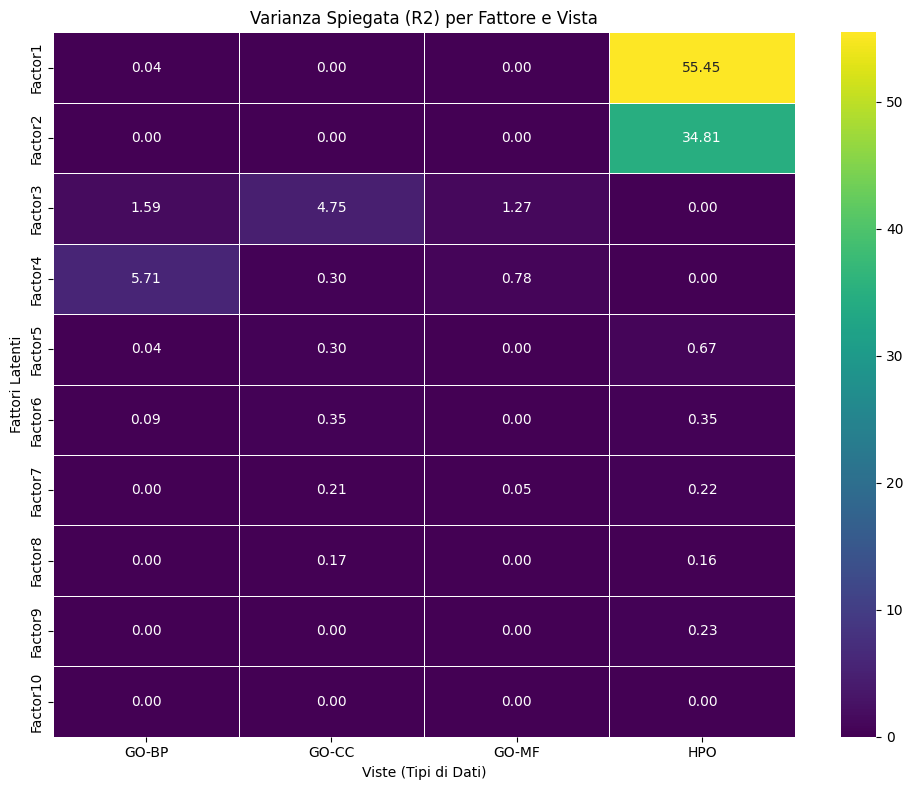

In [5]:
MODEL_OUTPUT_FILE = "C:\\Users\\husse\\Desktop\\Uni\\ScientificVisualization\\mofa_model_final.hdf5"
model = mofax.mofa_model(MODEL_OUTPUT_FILE)

r2_df = model.get_variance_explained()

r2_matrix = r2_df.pivot(index='Factor', columns='View', values='R2')

sorted_index = sorted(r2_matrix.index, key=lambda x: int(x.replace("Factor", "")))
r2_matrix = r2_matrix.reindex(sorted_index)

plt.figure(figsize=(10, 8))
sns.heatmap(
    r2_matrix, 
    cmap="viridis",
    annot=True,
    fmt=".2f",
    linewidths=.5
)

plt.title("Varianza Spiegata (R2) per Fattore e Vista")
plt.ylabel("Fattori Latenti")
plt.xlabel("Viste (Tipi di Dati)")
plt.tight_layout()
plt.show()

In [ ]:
# Load Model
model = mofax.mofa_model(MODEL_OUTPUT_FILE)

# File Paths Configuration
file_paths = {
    'GO-BP': r"C:\Users\nicki\Desktop\magi\Anno 1\Q1\ScientificVisualization\filtered_final_BP.csv",
    'GO-CC': r"C:\Users\nicki\Desktop\magi\Anno 1\Q1\ScientificVisualization\filtered_final_CC.csv", 
    'GO-MF': r"C:\Users\nicki\Desktop\magi\Anno 1\Q1\ScientificVisualization\filtered_final_MF.csv",
    'HPO':   r"C:\Users\nicki\Desktop\magi\Anno 1\Q1\ScientificVisualization\filtered_final_HPO.csv"
}

def get_term_description(term_id):
    
    try:
        # Fetch GO Terms
        if term_id.startswith("GO."):
            term_id = term_id.replace(".", ":")
            url = f"https://www.ebi.ac.uk/QuickGO/services/ontology/go/terms/{term_id}"
            response = requests.get(url, headers={"Accept": "application/json"}, timeout=2)
            if response.status_code == 200:
                return response.json()['results'][0]['name']
        
        # Fetch HPO Terms
        elif term_id.startswith("HP:"):
            url = f"https://ontology.jax.org/api/hp/terms/{term_id}"
            response = requests.get(url, timeout=2)
            if response.status_code == 200:
                return response.json()['name']
                
    except Exception:
        print(f"Error fetching description for {term_id}")
    
    return term_id

def plot_weights_fixed_translated(view_name, factor_index=0, n_top=5):
    # Load Weights
    try:
        w_df = model.get_weights(views=view_name, factors=factor_index, df=True)
    except Exception as e:
        print(f"Error loading weights: {e}")
        return

    # Fix Feature Names from CSV
    try:
        if view_name in file_paths:
            csv_cols = pd.read_csv(file_paths[view_name], index_col=0, nrows=0).columns.tolist()
            
            if len(csv_cols) == len(w_df):
                w_df.index = csv_cols
            else:
                print(f"Warning: Column count mismatch for {view_name}. Using generic IDs.")
    except Exception as e:
        print(e)

    col_name = None
    for c in w_df.columns:
        if pd.api.types.is_numeric_dtype(w_df[c]):
            col_name = c
            break     
    if col_name is None: return

    w_df['abs_val'] = w_df[col_name].abs()
    top_features = w_df.sort_values('abs_val', ascending=False).head(n_top)

    new_labels = [] 

    for term_id, row in top_features.iterrows():
        desc = get_term_description(term_id)
        weight_val = row[col_name]
        
        short_desc = (desc[:40] + '..') if len(desc) > 40 else desc
        new_labels.append(f"{term_id}\n{short_desc}")

    top_features.index = new_labels

    # Plotting
    plt.figure(figsize=(12, 10))
    sns.barplot(
        data=top_features,
        x=col_name,
        y=top_features.index,
        palette="viridis"
    )
    
    plt.title(f"Top {n_top} Features - {view_name} - Factor {factor_index+1}")
    plt.xlabel("Weight")
    plt.ylabel("")
    plt.axvline(0, color='black', linewidth=0.8)
    plt.tight_layout()
    plt.show()

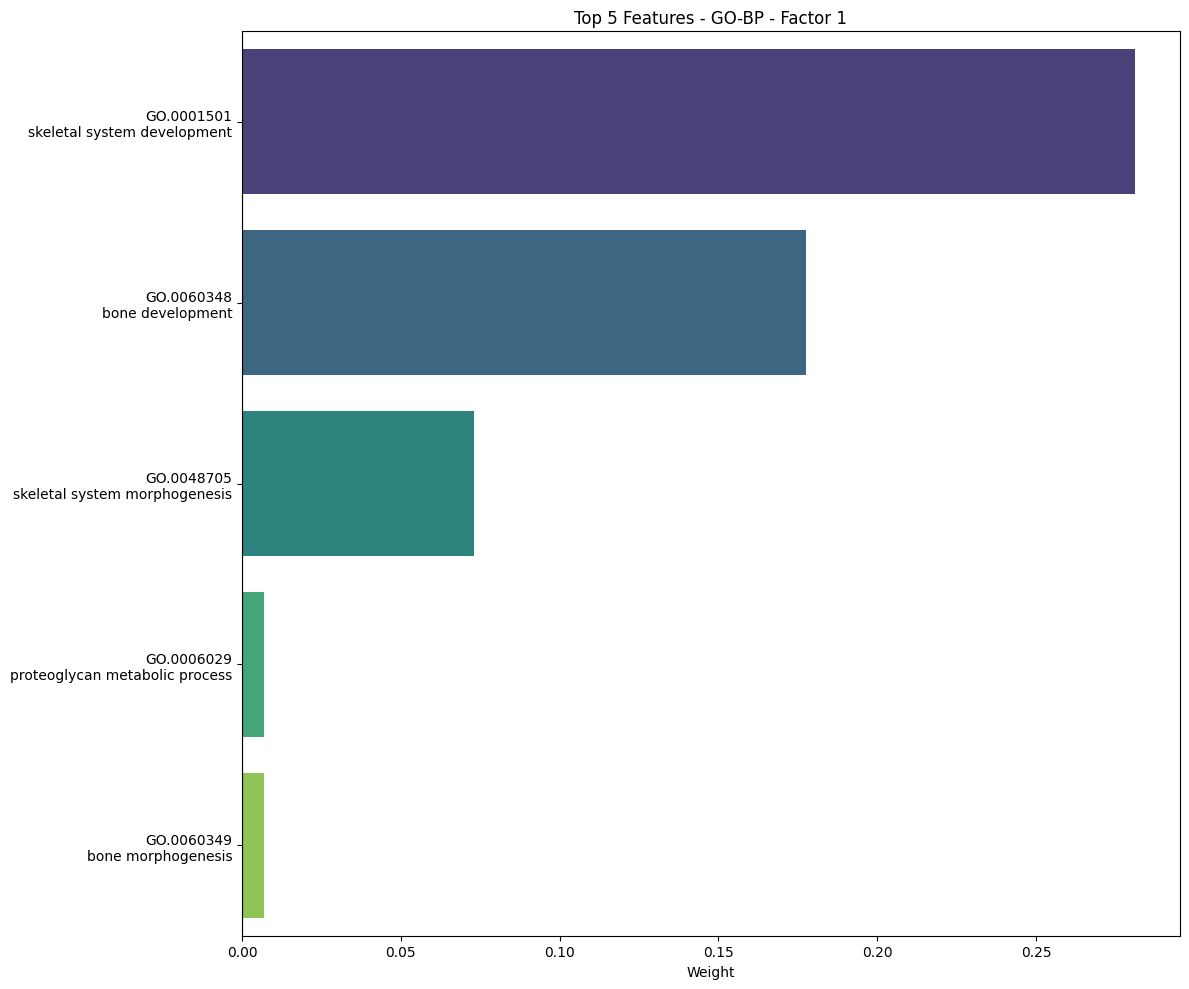

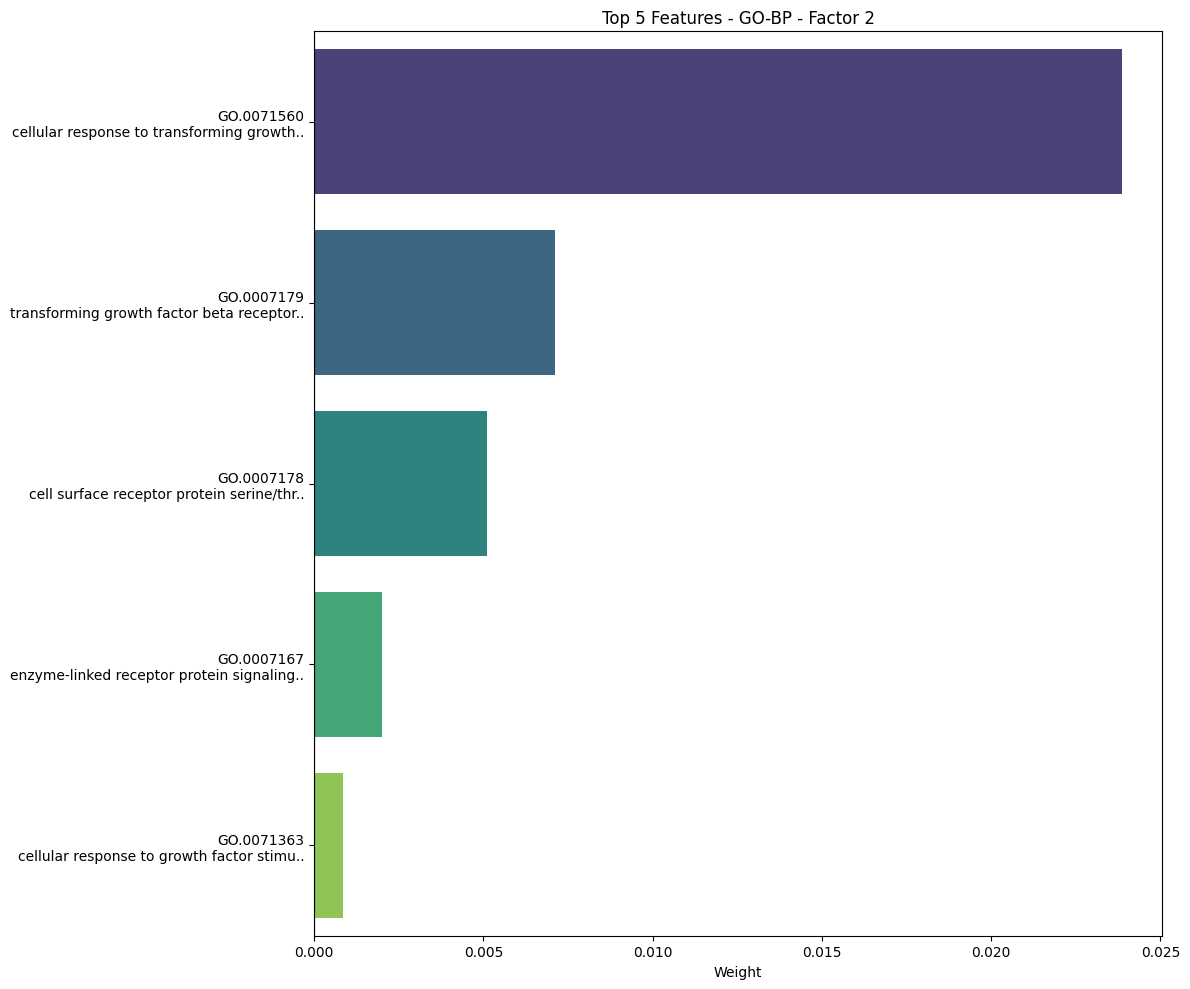

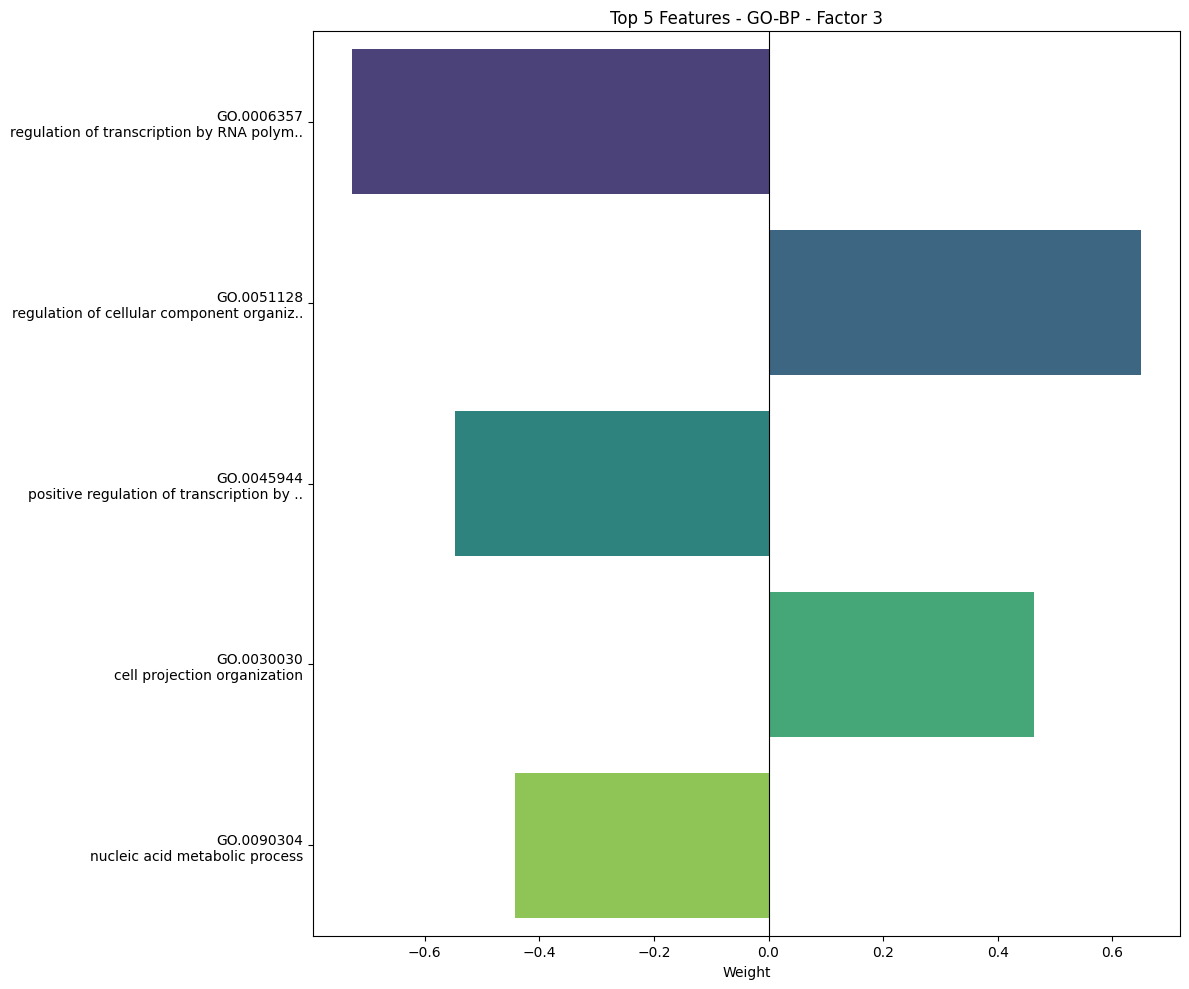

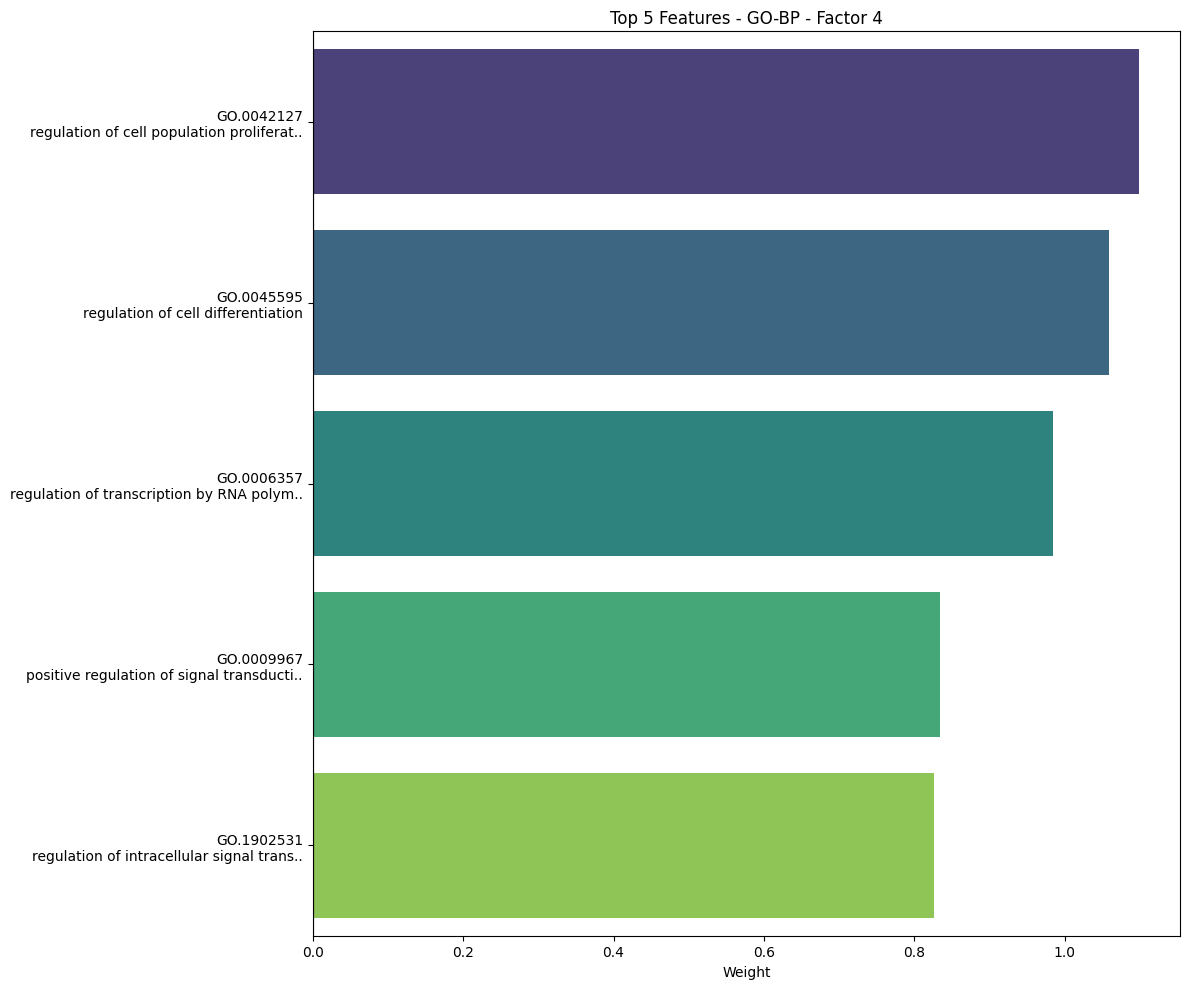

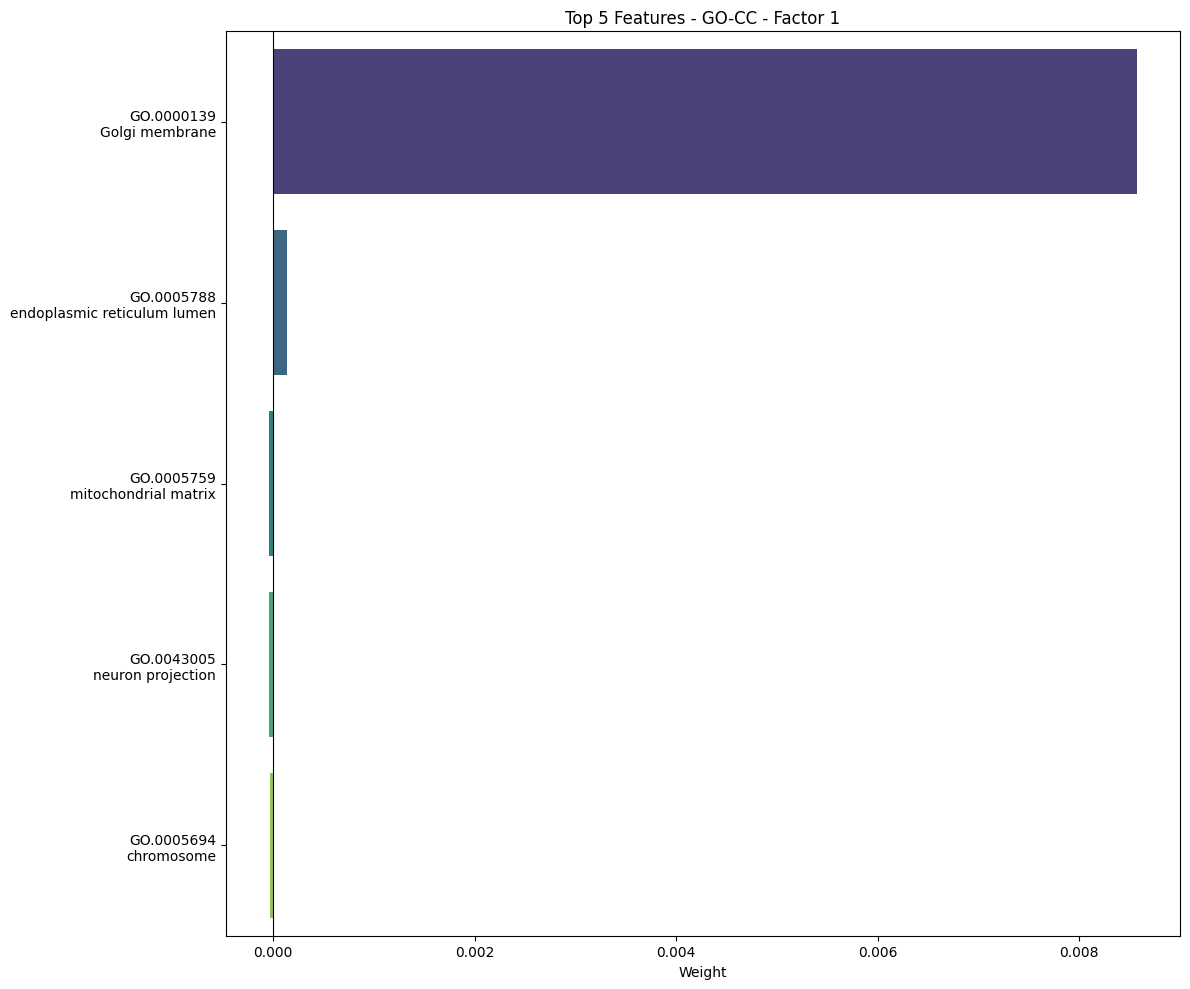

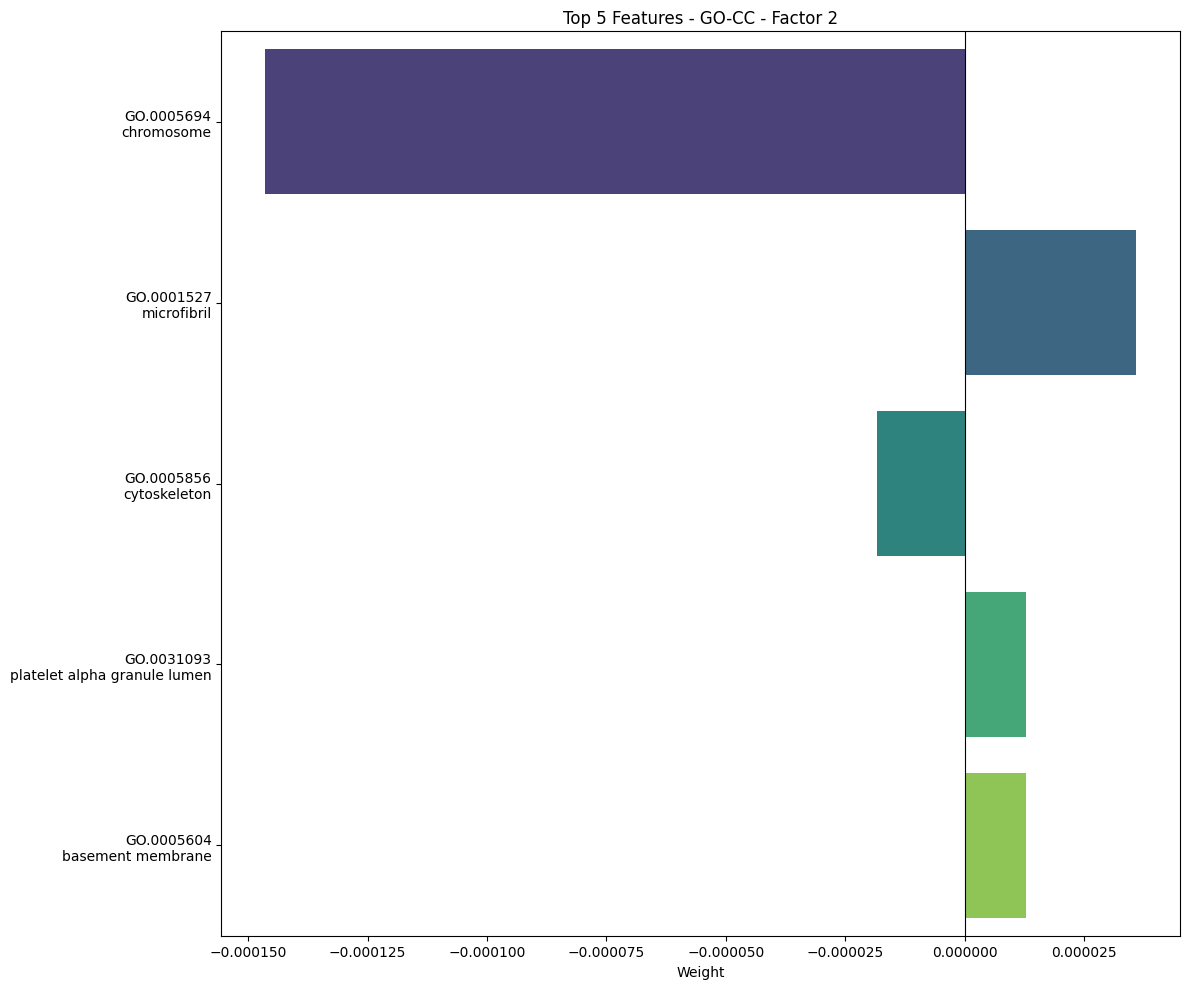

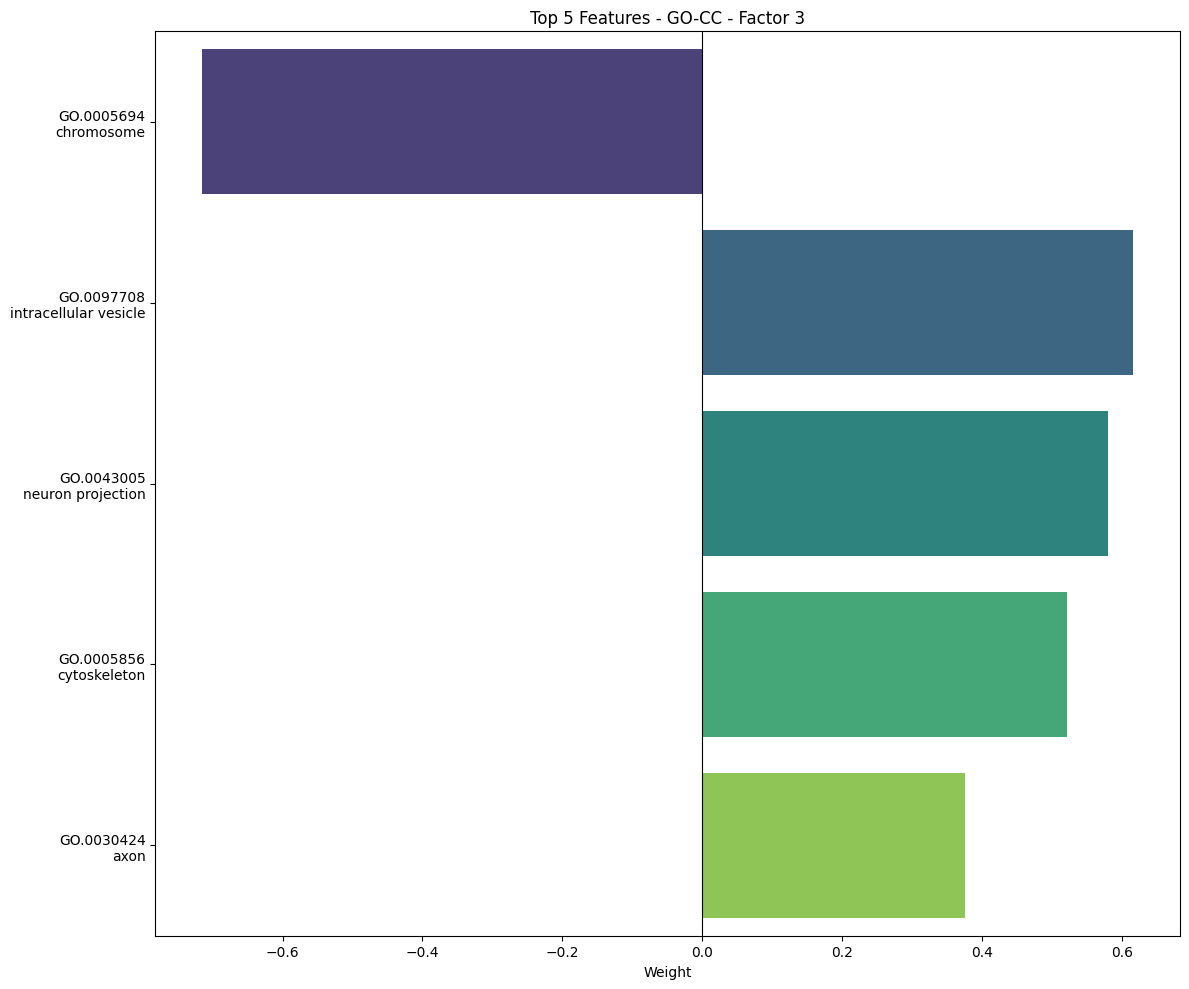

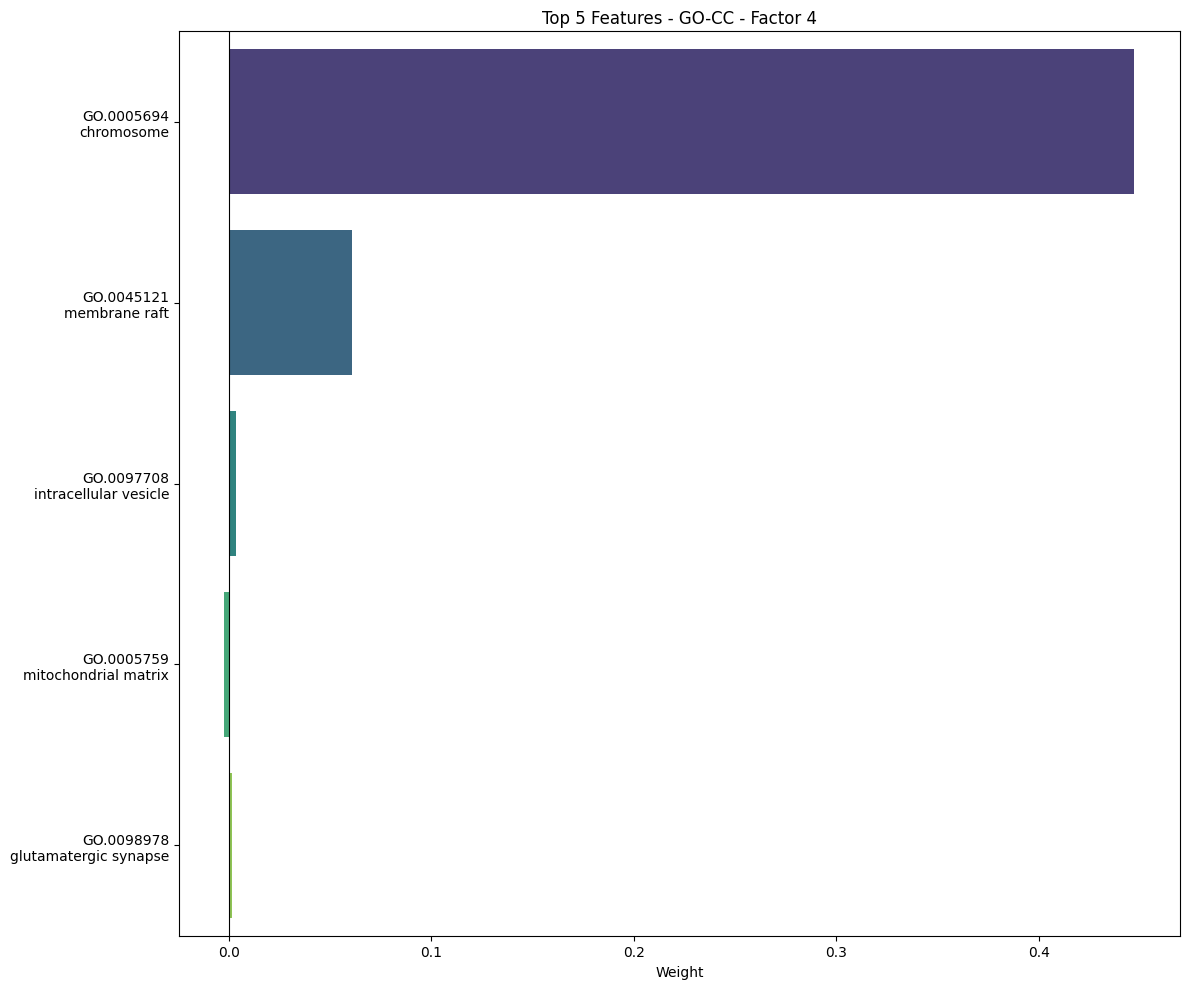

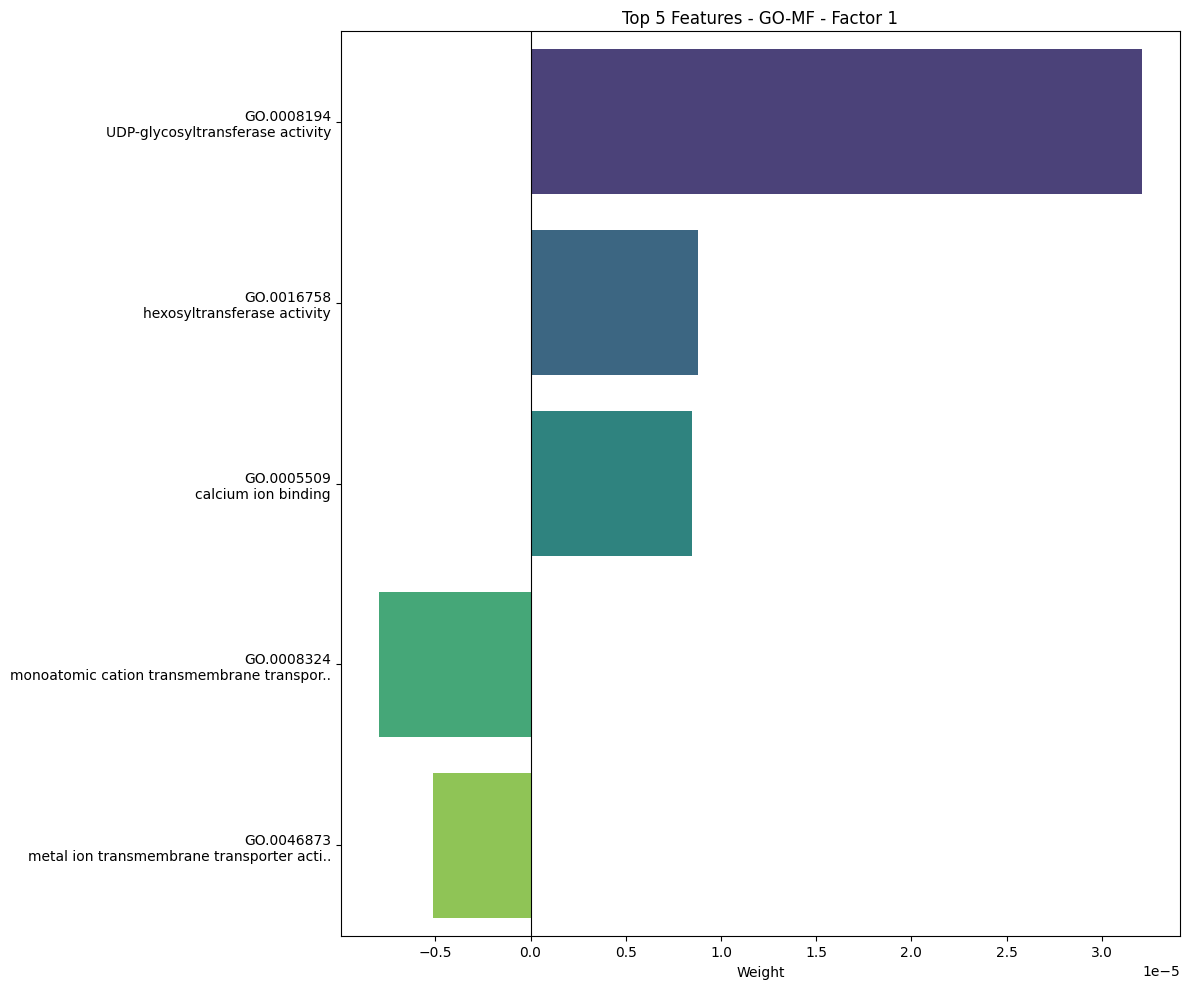

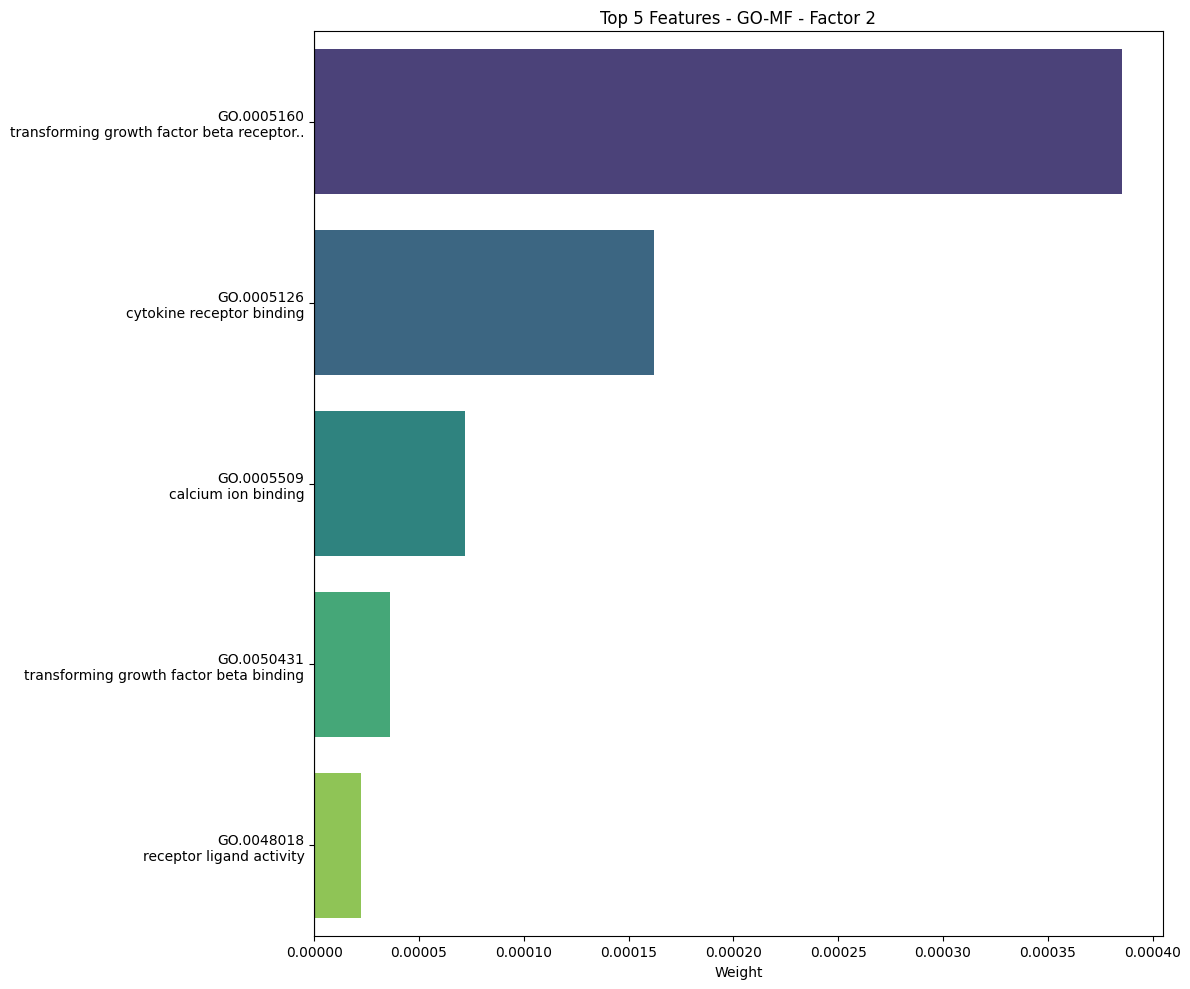

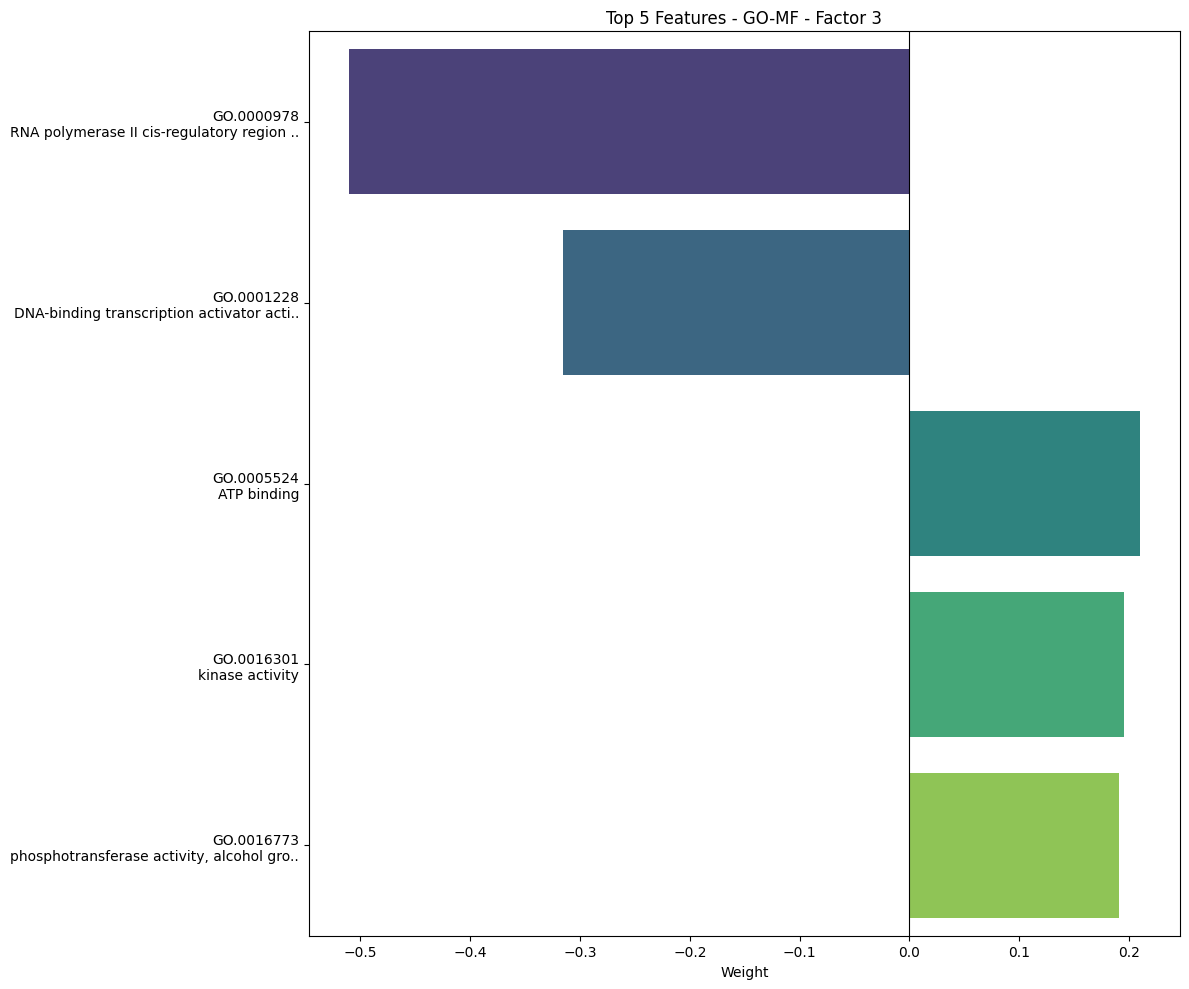

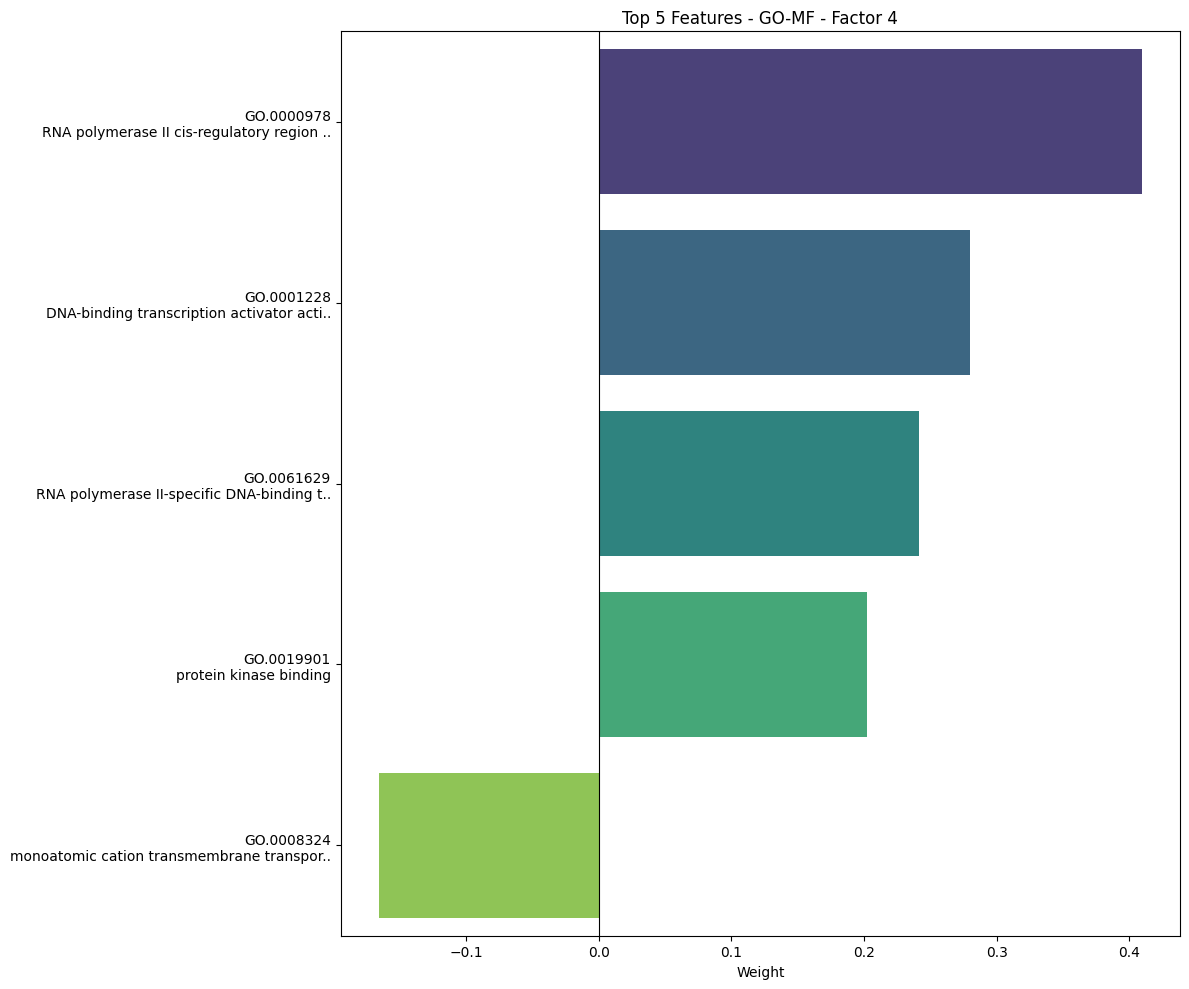

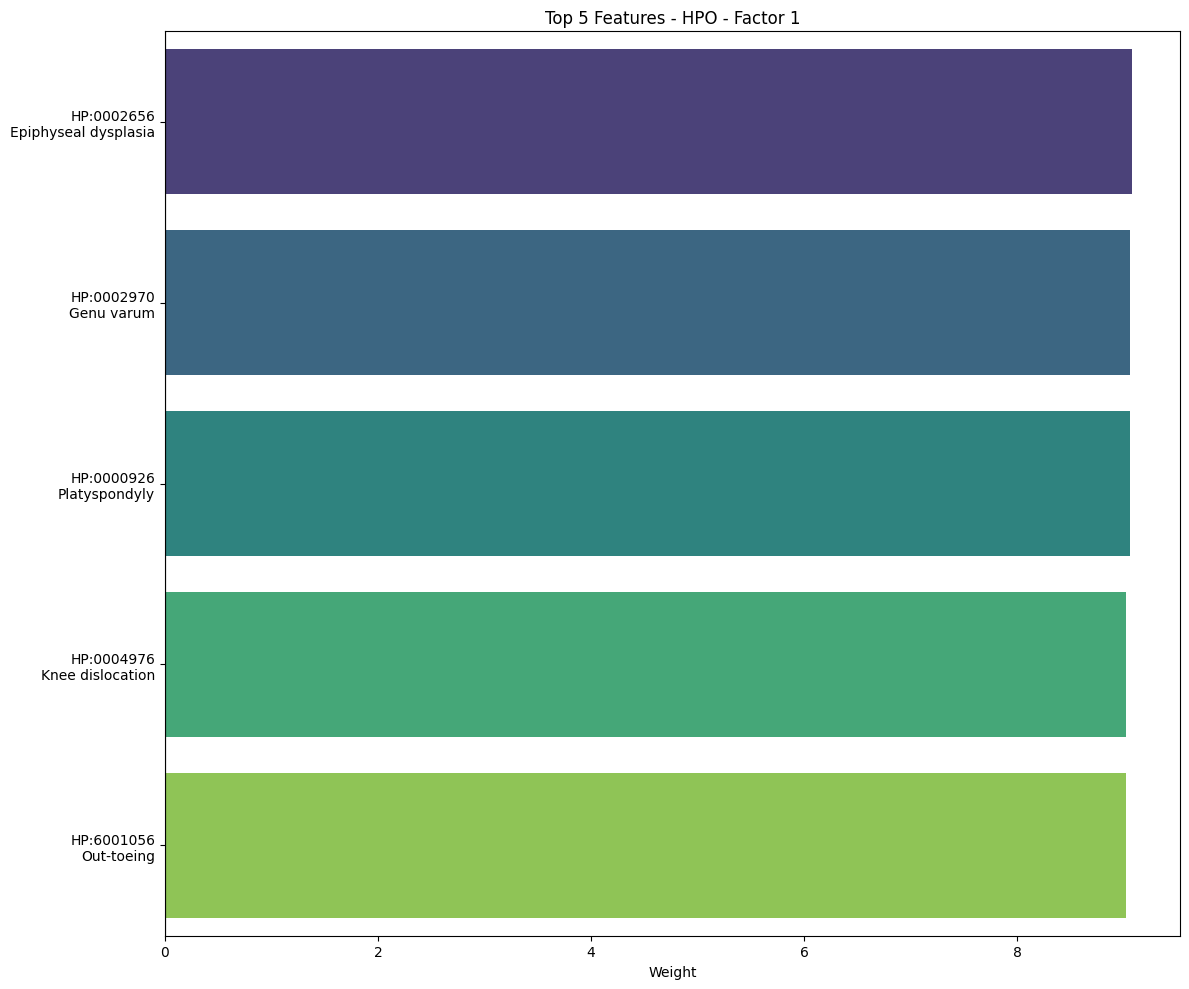

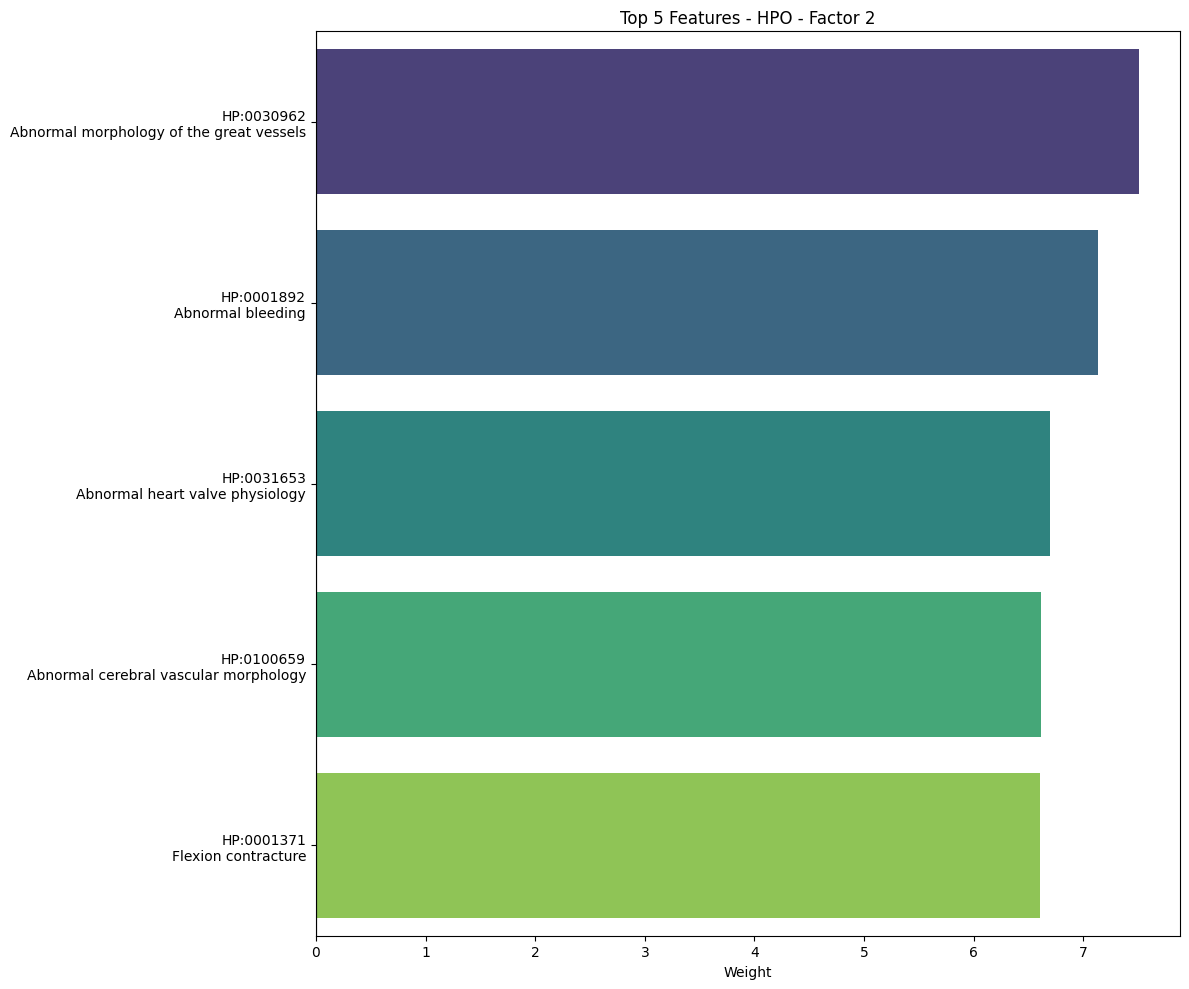

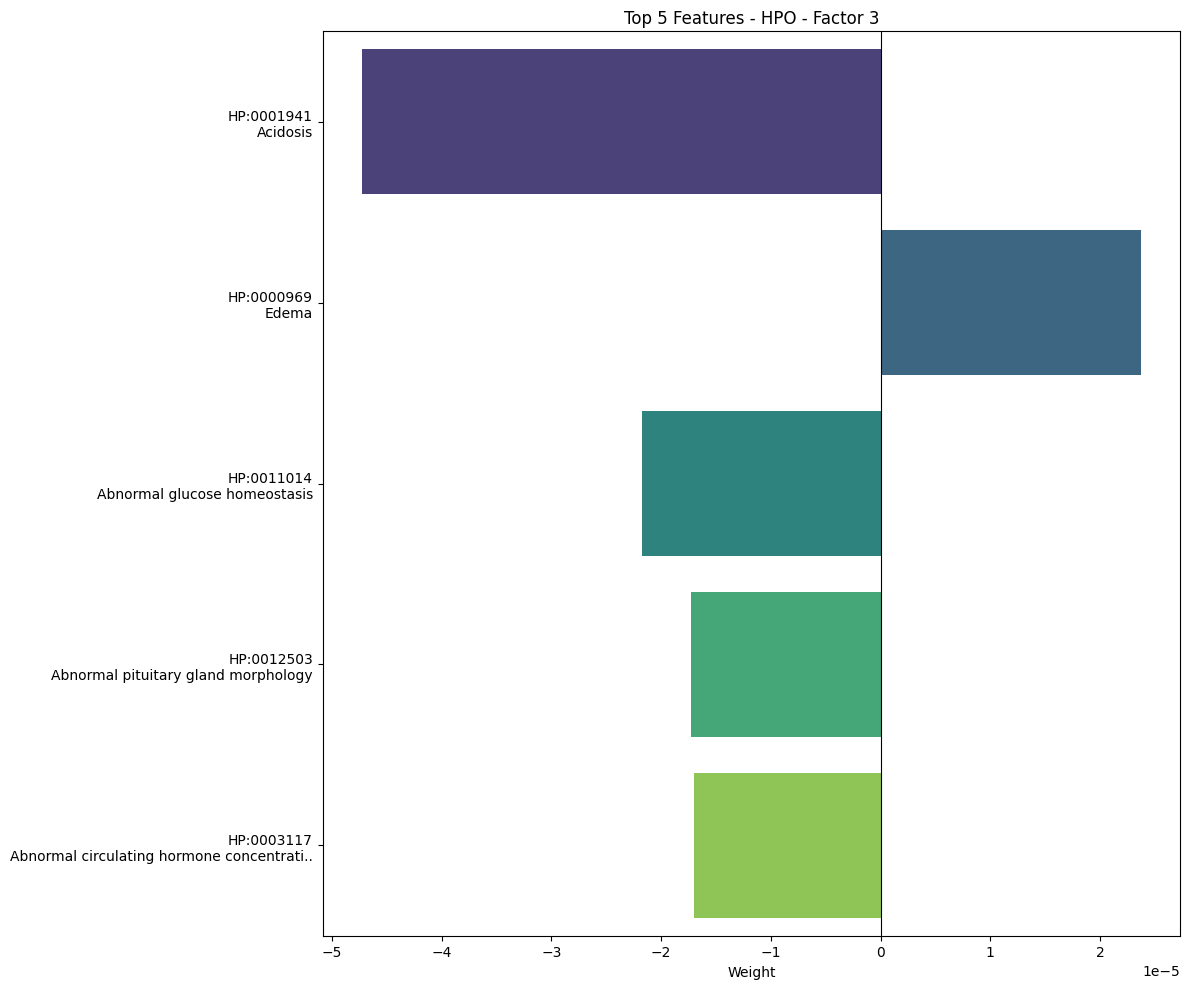

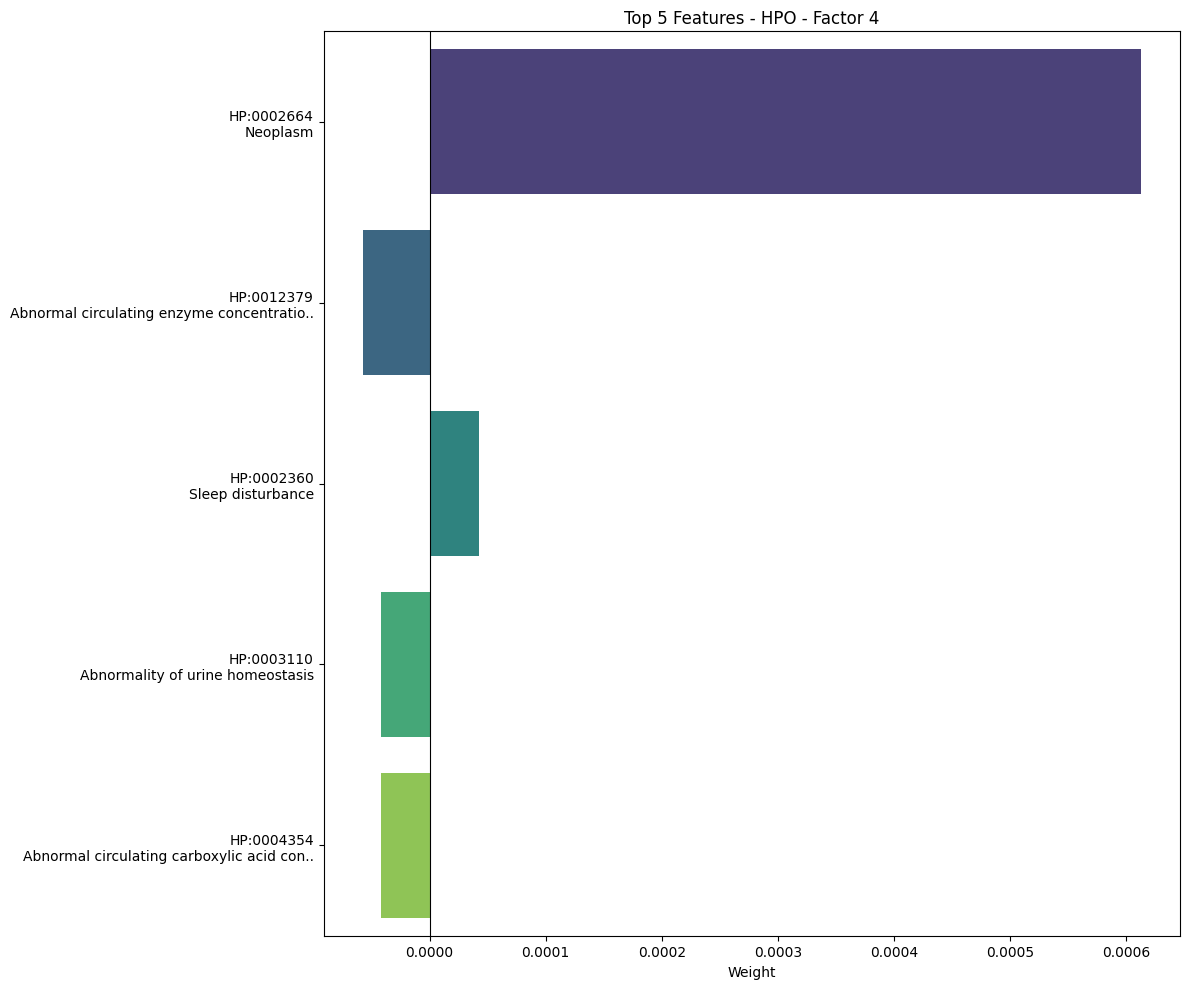

In [15]:
for vista in model.views:
    for i in range(4):
        plot_weights_fixed_translated(vista, factor_index=i)

In [ ]:
def plot_all_views_aggregated(factor_index=0, n_top=15):
    """
    Cicla su tutte le view in file_paths, unisce i pesi, 
    ordina per valore assoluto globale e plotta i top N.
    """
    
    all_weights_list = []
    
    for view_name in model.views:
        
        try:
            w_df = model.get_weights(views=view_name, factors=factor_index, df=True)
        except Exception as e:
            continue

        try:
            if view_name in file_paths:
                csv_cols = pd.read_csv(file_paths[view_name], index_col=0, nrows=0).columns.tolist()
                
                if len(csv_cols) == len(w_df):
                    w_df.index = csv_cols
        except Exception as e:
            print(e)

        val_col = None
        for c in w_df.columns:
            if pd.api.types.is_numeric_dtype(w_df[c]):
                val_col = c
                break
        
        if val_col is None:
            continue

        # Rinomina la colonna valore in 'weight' per poter concatenare tutto dopo
        w_df = w_df.rename(columns={val_col: 'weight'})
        
        # Aggiunge colonna per tracciare la provenienza (es. 'mRNA', 'Methylation')
        w_df['view'] = view_name
        
        # Salviamo l'ID originale (il nome del gene/feature)
        w_df['feature_id'] = w_df.index
        
        all_weights_list.append(w_df[['weight', 'view', 'feature_id']])

    if not all_weights_list:
        print("Nessun peso caricato.")
        return

    combined_df = pd.concat(all_weights_list, axis=0)
    combined_df['abs_val'] = combined_df['weight'].abs()
    top_features = combined_df.sort_values('abs_val', ascending=False).head(n_top)

    new_labels = []
    for _, row in top_features.iterrows():
        term_id = row['feature_id']
        view_source = row['view']
        
        # Chiama la tua funzione di traduzione esterna
        try:
            desc = get_term_description(term_id)
        except:
            desc = term_id
            
        short_desc = (desc[:40] + '..') if len(desc) > 40 else desc
        
        new_labels.append(f"{term_id}\n{short_desc}")

    top_features['plot_label'] = new_labels

    plt.figure(figsize=(12, 10 + (n_top // 5)))
    
    sns.barplot(
        data=top_features,
        x='weight',
        y='plot_label',
        hue='view',
        dodge=False,
        palette="viridis"
    )
    
    plt.title(f"Top {n_top} Global Features - Factor {factor_index+1}")
    plt.xlabel("Weight")
    plt.ylabel("")
    plt.axvline(0, color='black', linewidth=0.8)
    plt.legend(title='View Source', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

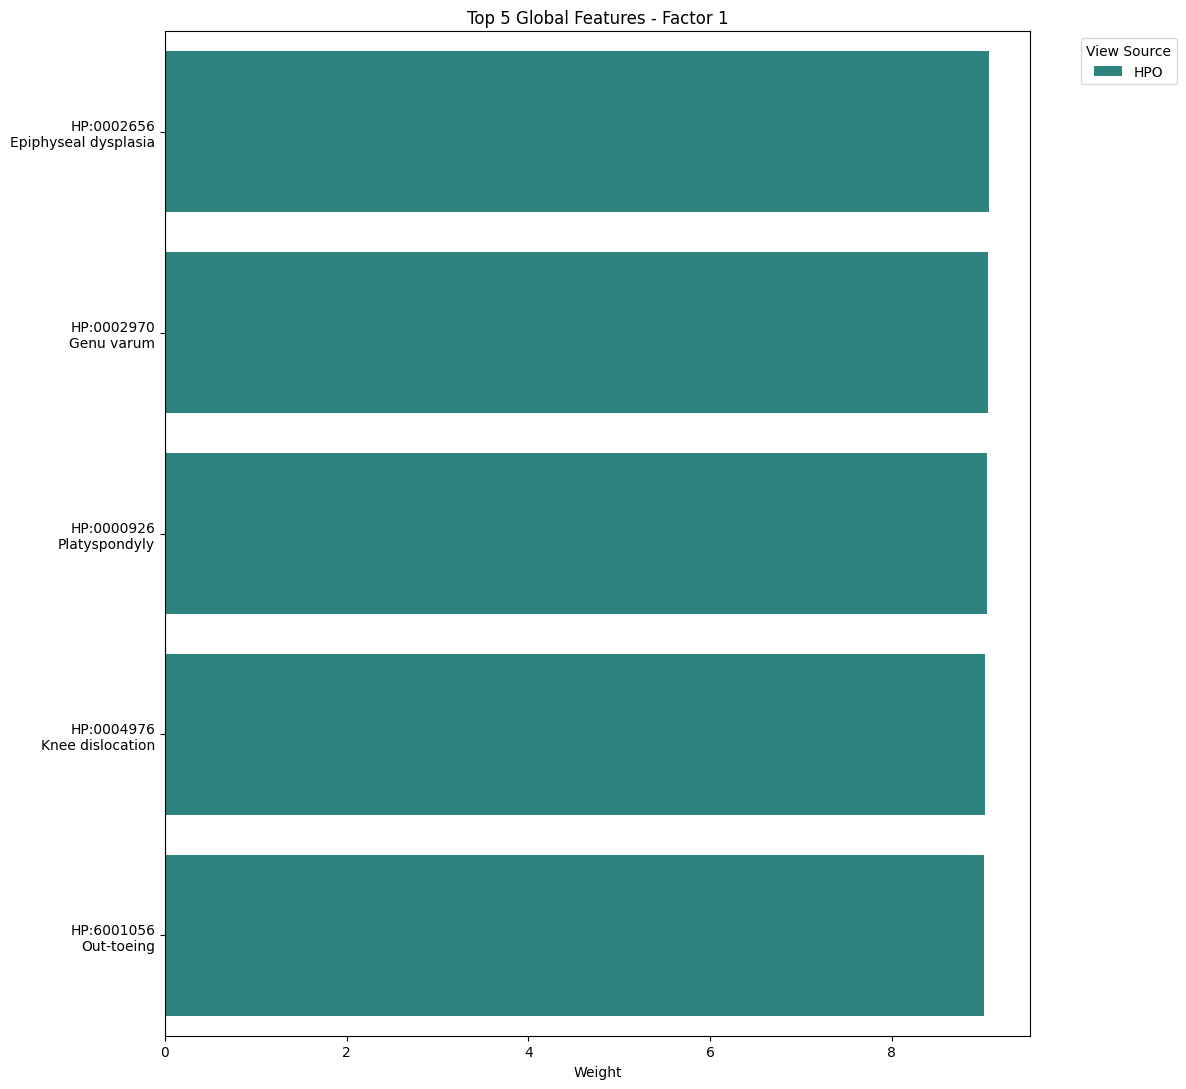

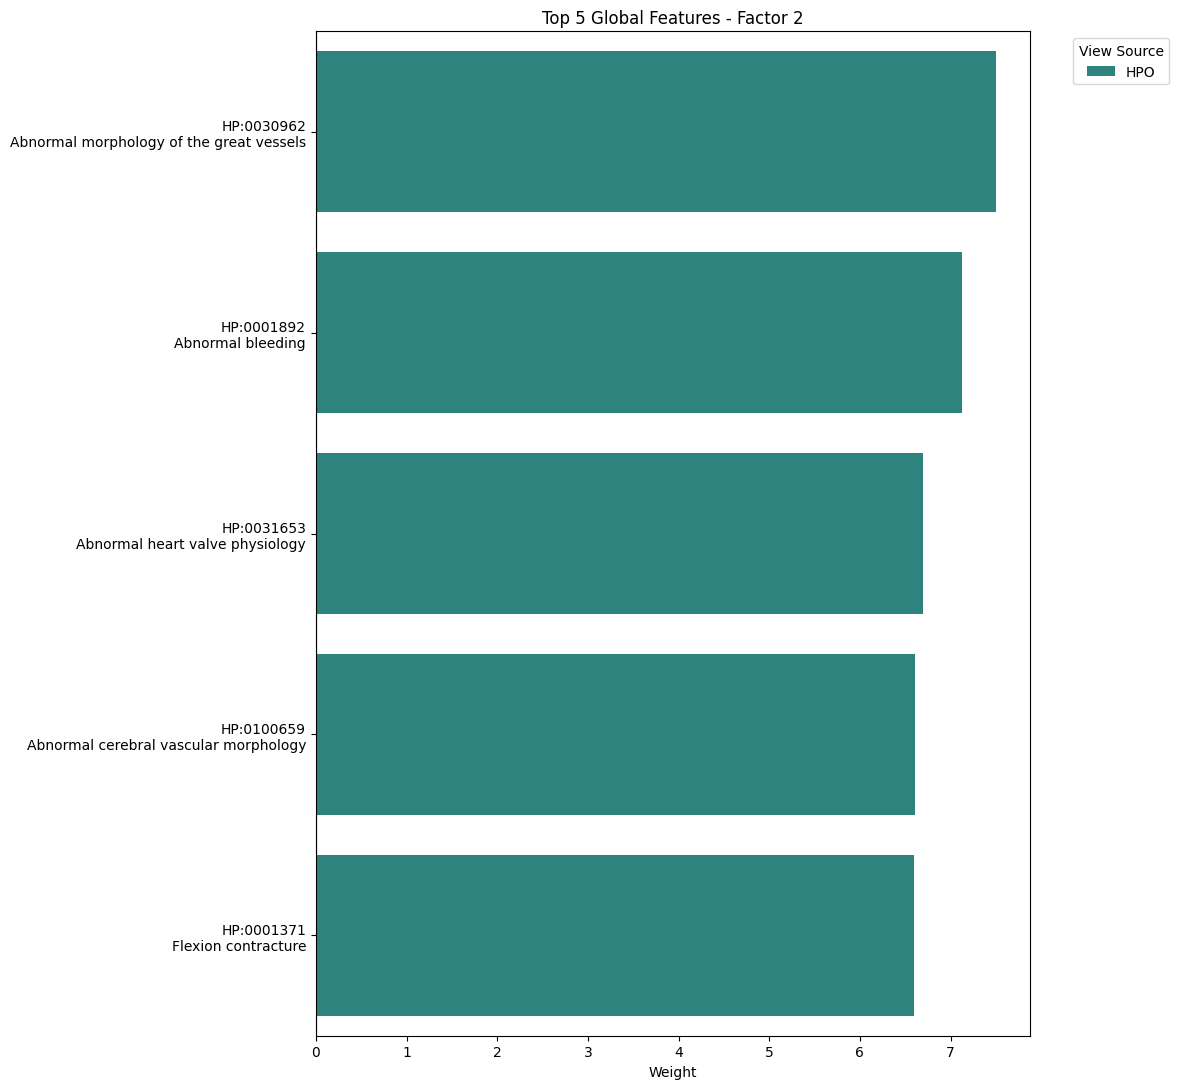

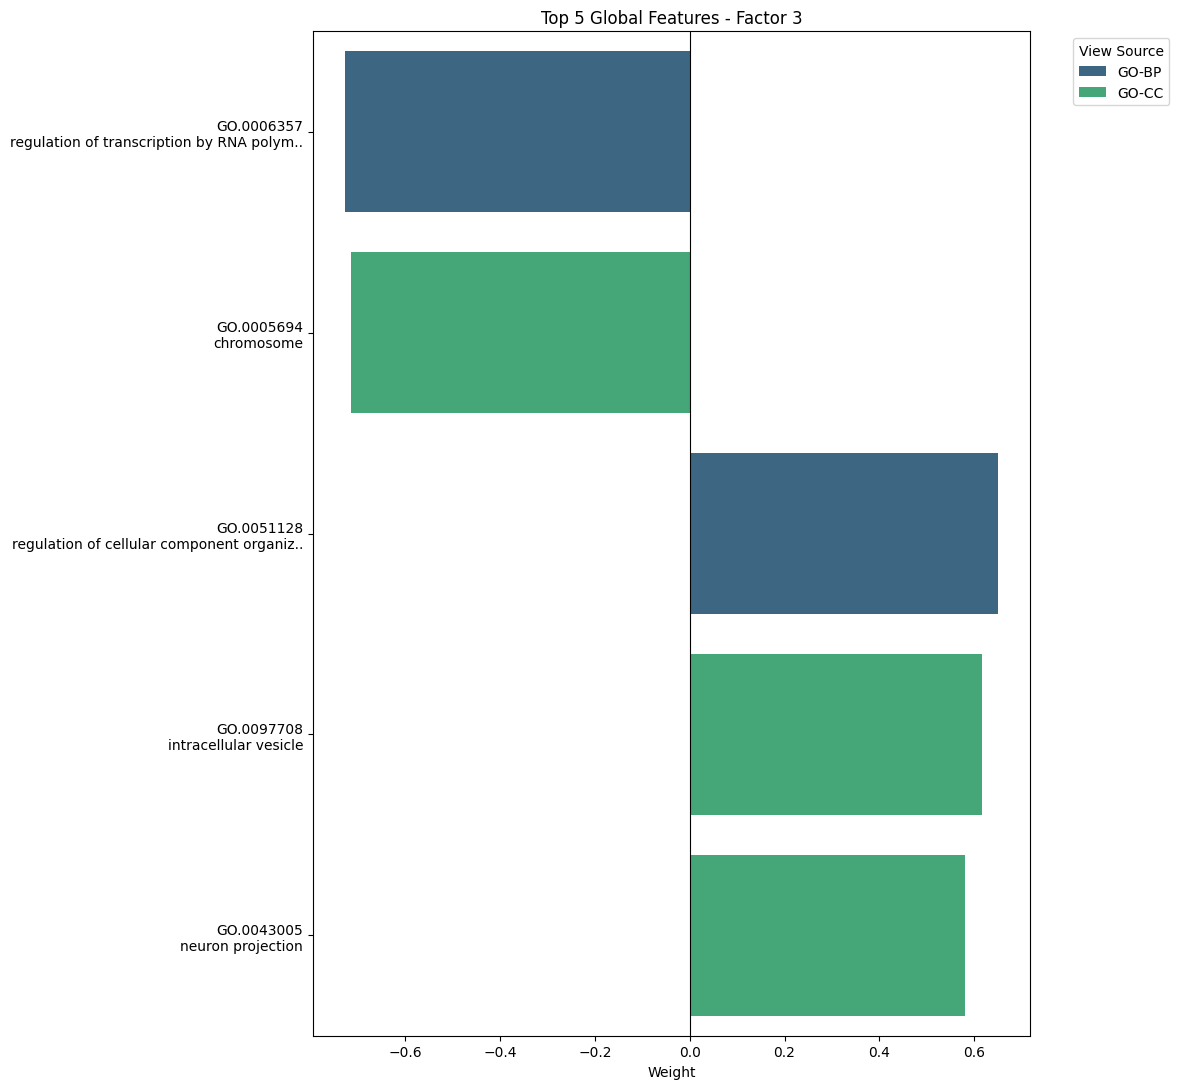

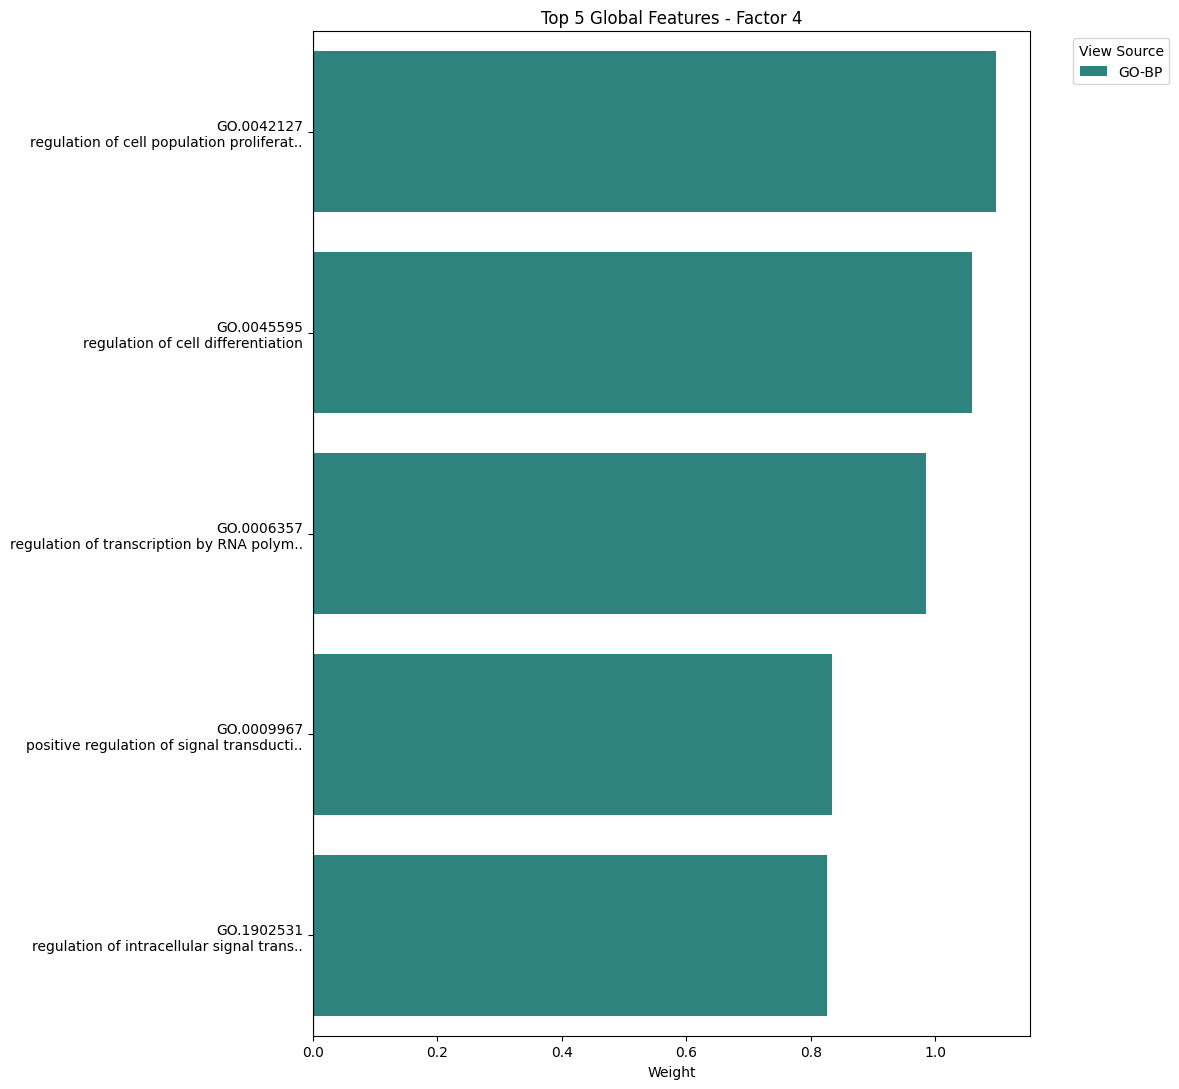

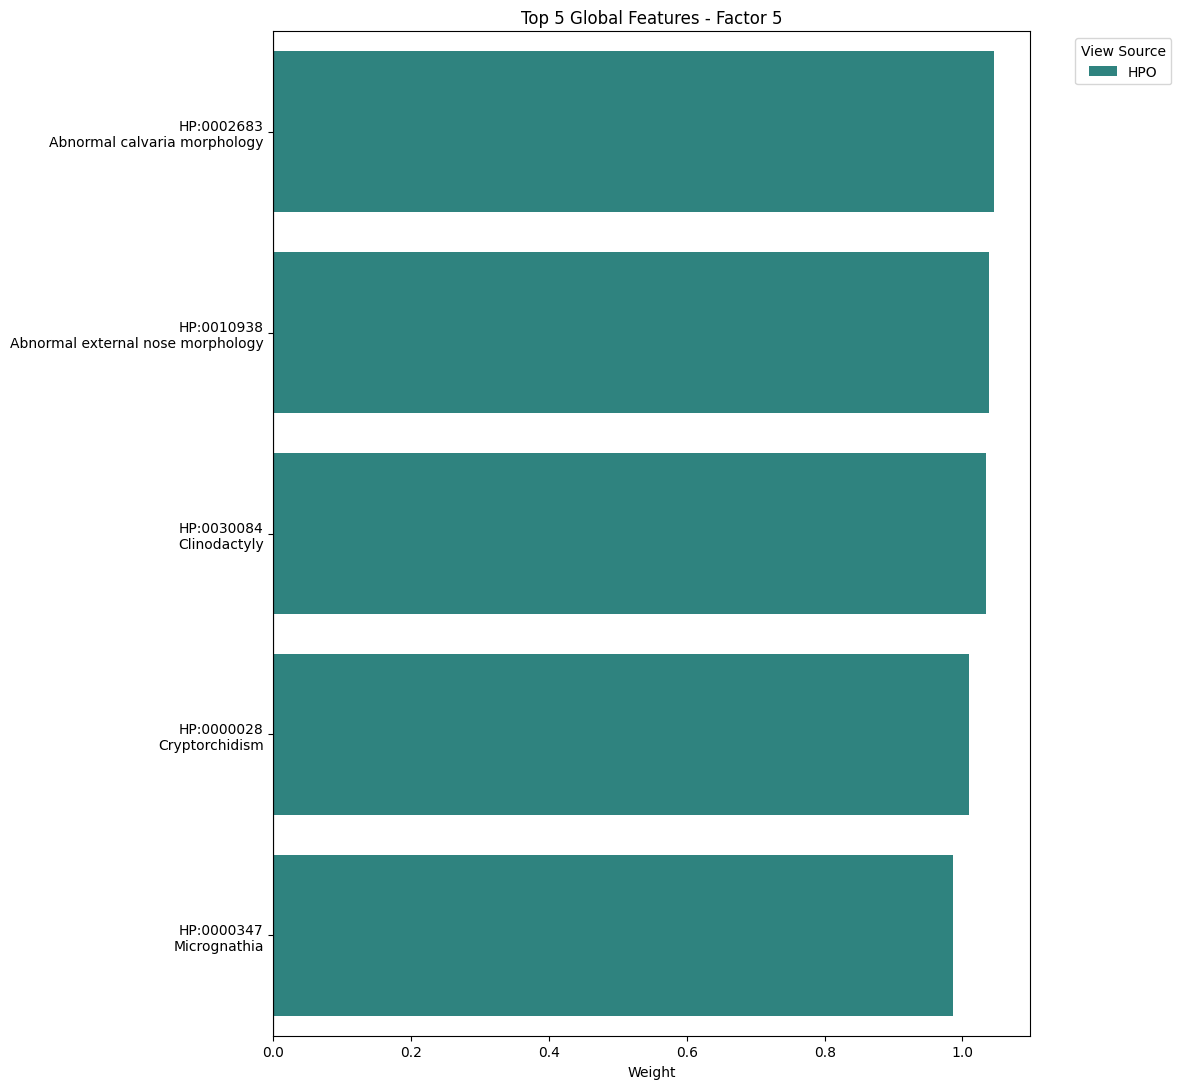

In [13]:
for factor_idx in range(5):
    plot_all_views_aggregated(factor_index=factor_idx, n_top=5)

In [ ]:
def analyze_view(sim_matrix_path, view_name):
    print(f"\n--- Analisi Vista: {view_name} ---")
    
    sim_df = pd.read_csv(sim_matrix_path, index_col=0)
    
    distance_matrix = 1 - sim_df.values
    distance_matrix[distance_matrix < 0] = 0
    
    reducer = umap.UMAP(
        n_neighbors=30,
        min_dist=0.1,
        n_components=2,
        metric='precomputed',
        random_state=42
    )
    
    embedding = reducer.fit_transform(distance_matrix)
    
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=30,
        metric='euclidean',
        cluster_selection_method='eom'
    )
    
    cluster_labels = clusterer.fit_predict(embedding)
    
    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    n_noise = list(cluster_labels).count(-1)

    plt.figure(figsize=(10, 8))
    
    noise_color = (0.8, 0.8, 0.8)
    palette = sns.color_palette('tab20', n_colors=n_clusters)
    cluster_colors = [palette[x] if x >= 0 else noise_color for x in cluster_labels]
    
    plt.scatter(
        embedding[:, 0], 
        embedding[:, 1], 
        c=cluster_colors, 
        s=5, 
        alpha=0.6
    )
    
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Noise', 
               markerfacecolor=noise_color, markersize=10),
    ]
    plt.legend(handles=legend_elements, loc='upper right')

    plt.title(f'UMAP Projection - {view_name} ({n_clusters} clusters)', fontsize=16)
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    
    plt.savefig(f"plot_umap_{view_name}.png", dpi=300)
    plt.close()
    
    results = pd.DataFrame({
        'Gene': sim_df.index,
        'Cluster': cluster_labels,
        'UMAP_1': embedding[:, 0],
        'UMAP_2': embedding[:, 1]
    })
    results.to_csv(f"clusters_{view_name}.csv", index=False)
    
    return n_clusters, n_noise

In [ ]:
files = {
    "BP": "snf_similarity_BP.csv",
    "CC": "snf_similarity_CC.csv",
    "MF": "snf_similarity_MF.csv",
    "HPO": "snf_similarity_HPO.csv"
}

summary = []
for name, path in files.items():
    n_clust, n_noise = analyze_view(path, name)
    summary.append({'View': name, 'Clusters': n_clust, 'Noise_Genes': n_noise})

print(pd.DataFrame(summary))

In [ ]:
import pandas as pd
import snf
import os
import numpy as np

def run_snf_with_affinity_calculation(view_names, output_dir='.'):
    """
    1. Carica le matrici di dati originali (Feature Matrix).
    2. Calcola la matrice di affinità per ciascuna vista usando snf.make_affinity.
    3. Fonde le affinità con snf
    """
    affinity_matrices = []
    gene_list = None

    K = 20 
    mu = 0.5 
    
    for name in view_names:

        filename = f"mofa_input_{name}.csv" 
        file_path = os.path.join(output_dir, filename)
        
        df = pd.read_csv(file_path, index_col=0)
        
        if gene_list is None:
            gene_list = df.index.tolist()
        elif df.index.tolist() != gene_list:
            continue
        
        data_matrix = df.values
        
        affinity = snf.make_affinity(data_matrix, metric='euclidean', K=K, mu=mu)
        
        affinity_matrices.append(affinity)

    t = 20    
    W_fused = snf.snf(affinity_matrices, K=K, t=t)
    
    df_fused = pd.DataFrame(W_fused, index=gene_list, columns=gene_list)
    output_file = os.path.join(output_dir, "snf_fused_matrix_calculated.csv")
    df_fused.to_csv(output_file)
    
    return df_fused

In [ ]:
view_names = ["BP", "CC", "MF", "HPO"]
df_fused_snf = run_snf_with_affinity_calculation(view_names)

if df_fused_snf is not None:
    print(f"\nRange Matrice Fusa: [{df_fused_snf.values.min():.4f}, {df_fused_snf.values.max():.4f}]")

In [ ]:
def visualize_snf_clustering(fused_matrix_path, min_cluster_size=15):
    
    df_fused = pd.read_csv(fused_matrix_path, index_col=0)
    W = df_fused.values
    distance_matrix = 1 - W
    
    distance_matrix[distance_matrix < 0] = 0
    np.fill_diagonal(distance_matrix, 0)
    
    reducer = umap.UMAP(
        metric='precomputed',
        n_neighbors=30,
        min_dist=0.1,
        n_components=2,
        random_state=42
    )
    embedding = reducer.fit_transform(distance_matrix)
    
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=5,
        metric='euclidean'
    )
    cluster_labels = clusterer.fit_predict(embedding)
    
    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    n_noise = list(cluster_labels).count(-1)

    plt.figure(figsize=(10, 8))
    
    plot_df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
    plot_df['Cluster'] = cluster_labels
    plot_df['Cluster'] = plot_df['Cluster'].astype(str)
    
    unique_labels = sorted(plot_df['Cluster'].unique(), key=lambda x: int(x))
    palette = sns.color_palette("tab10", len(unique_labels))
    color_map = dict(zip(unique_labels, palette))
    
    if '-1' in color_map:
        color_map['-1'] = (0.8, 0.8, 0.8)
        
    sns.scatterplot(
        data=plot_df,
        x='UMAP1', y='UMAP2',
        hue='Cluster',
        palette=color_map,
        s=40,
        alpha=0.8,
        legend=False
    )
    
    plt.title(f"SNF Integration -> UMAP + HDBSCAN\n({n_clusters} Clusters)", fontsize=14)
    plt.tight_layout()
    plt.show()
    df_results = pd.DataFrame({
        'Gene': df_fused.index,
        'Cluster': cluster_labels,
        'UMAP1': embedding[:, 0],
        'UMAP2': embedding[:, 1]
    })
    
    return df_results

risultati = visualize_snf_clustering("snf_fused_matrix_calculated.csv", min_cluster_size=20)

In [ ]:
risultati

In [13]:
risultati_puliti = risultati[risultati['Cluster'] != -1]

In [14]:
risultati_puliti

,Gene,Cluster,UMAP1,UMAP2
0,16,1,20.324976,0.213749
1,18,19,19.036985,-0.854403
2,19,39,16.780445,1.524935
3,20,39,16.699015,1.401814
4,21,39,16.694801,1.716174
...,...,...,...,...
3309,653361,33,17.574051,2.784674
3310,727857,22,20.043150,4.381875
3312,729230,34,18.515450,2.504360
3314,100127206,32,17.007570,2.620951


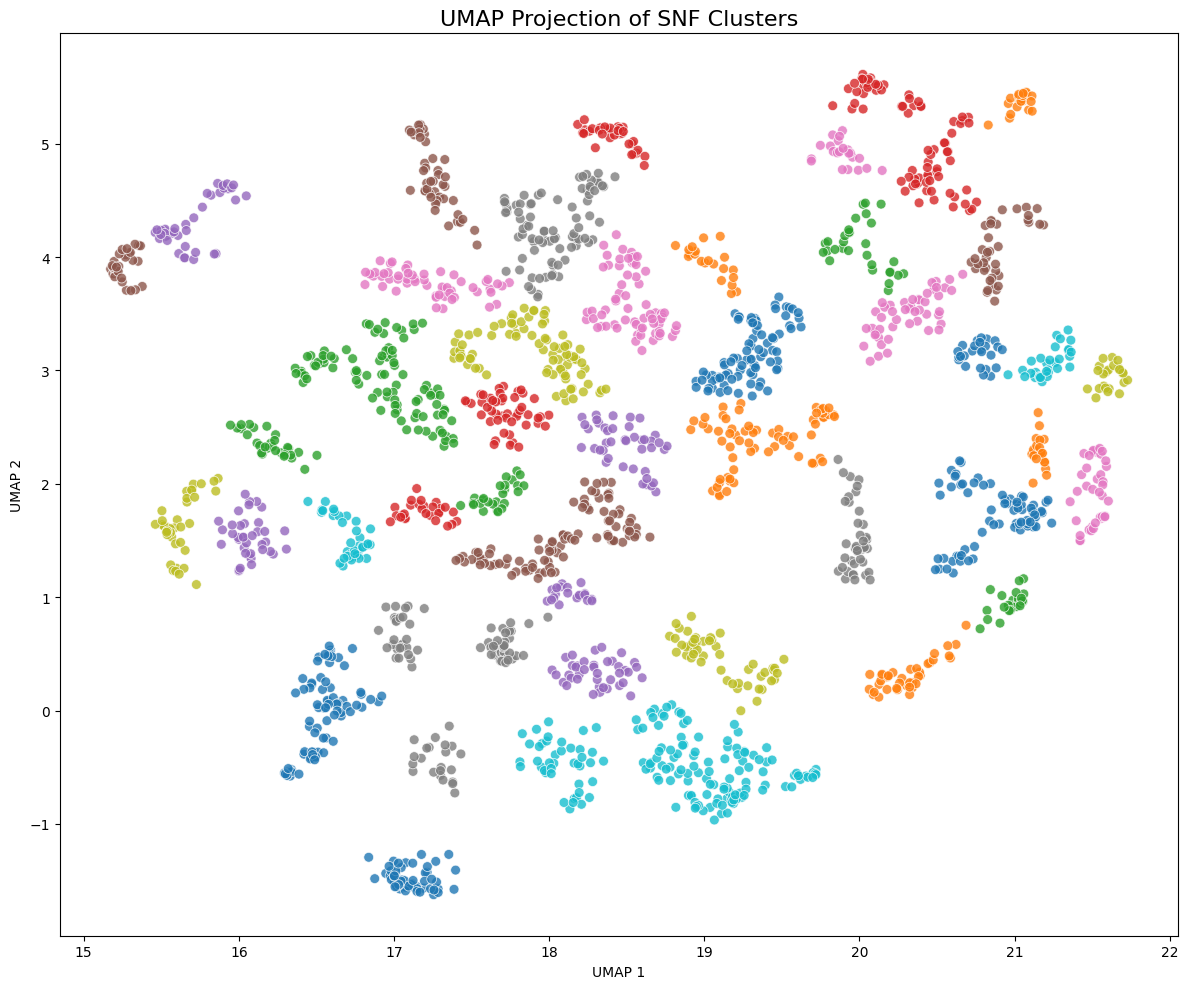

In [18]:
plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=risultati_puliti,
    x='UMAP1', 
    y='UMAP2',
    hue='Cluster',
    palette="tab10",
    s=50,
    alpha=0.8,
    legend=False
)
plt.title("UMAP Projection of SNF Clusters", fontsize=16)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.tight_layout()
plt.show()

In [19]:
risultati_puliti.to_csv("snf_clusters_results.csv", index=False)

Centroids of each cluster:
    Cluster      UMAP1     UMAP2
0         0  17.099262 -1.482042
1         1  20.308882  0.306716
2         2  20.975075  0.950523
3         3  20.101336  5.473134
4         4  15.716038  4.328093
5         5  15.254506  3.919934
6         6  19.890856  4.912796
7         7  17.281647 -0.444024
8         8  15.620804  1.626967
9         9  18.084599 -0.466412
10       10  16.538948 -0.028346
11       11  21.036835  5.375158
12       12  16.202570  2.351113
13       13  18.410109  5.065567
14       14  16.066952  1.531269
15       15  17.256376  4.712834
16       16  21.510998  1.932360
17       17  17.044491  0.669953
18       18  19.104435  0.461049
19       19  19.068155 -0.513039
20       20  20.874310  1.712449
21       21  21.158117  2.285017
22       22  20.009436  4.091763
23       23  20.510679  4.765066
24       24  18.308077  0.335074
25       25  20.892380  4.057312
26       26  20.315897  3.496751
27       27  17.711214  0.574718
28       28  21.

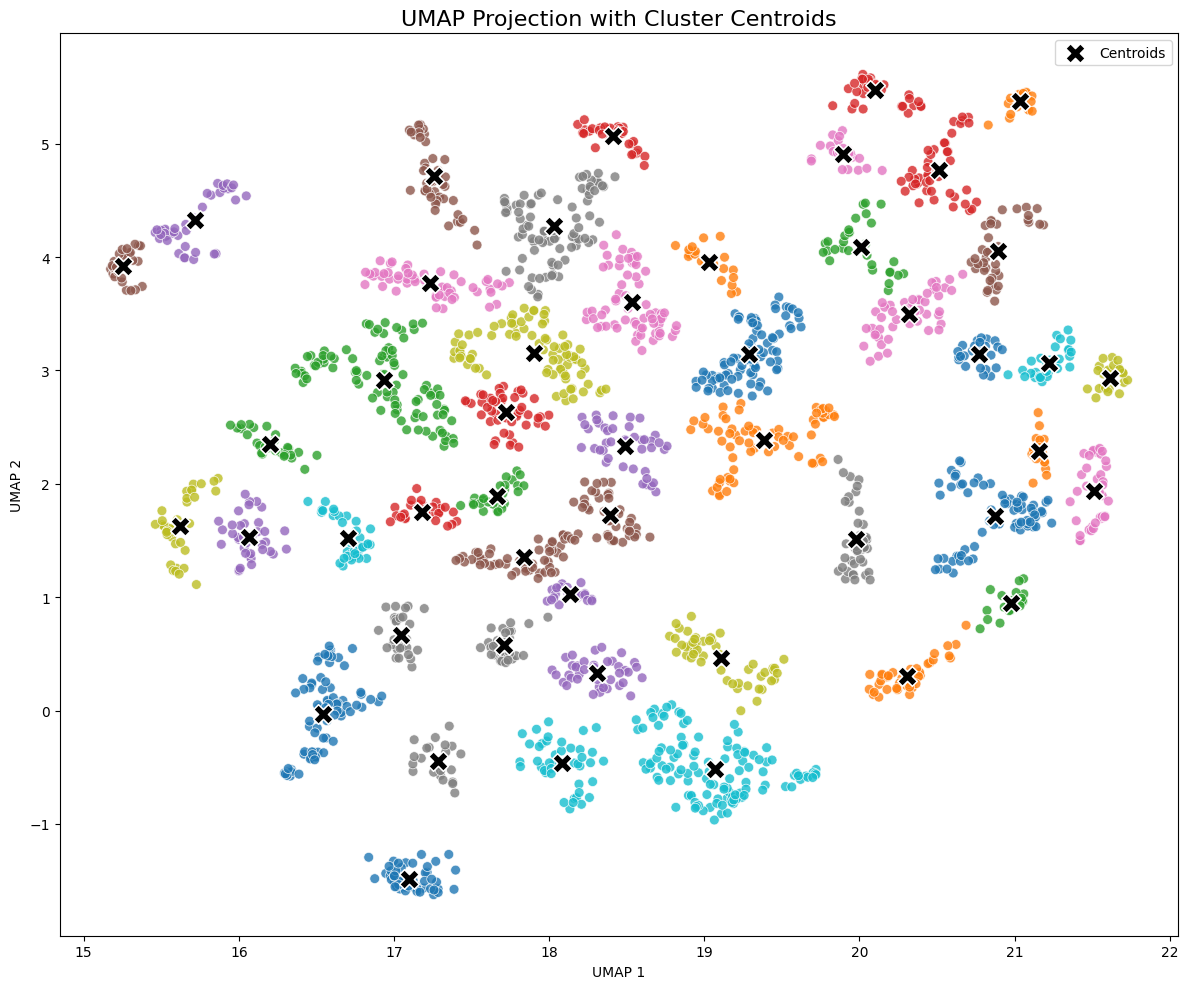

In [22]:
# Find centroids of each cluster
def find_cluster_centroids(results_df):
    centroids = results_df.groupby('Cluster')[['UMAP1', 'UMAP2']].mean().reset_index()
    return centroids
centroids = find_cluster_centroids(risultati_puliti)
print(f"Centroids of each cluster:\n{centroids}")

plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=risultati_puliti,
    x='UMAP1', 
    y='UMAP2',
    hue='Cluster',
    palette="tab10",
    s=50,
    alpha=0.8,
    legend=False
)

# Plot centroids
sns.scatterplot(
    data=centroids,
    x='UMAP1', 
    y='UMAP2',
    color='black',
    marker='X',
    s=200,
    label='Centroids'
)

plt.title("UMAP Projection with Cluster Centroids", fontsize=16)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.tight_layout()
plt.show()

In [ ]:
def find_closest_genes_to_centroids(results_df, centroids, n_closest=3):
    closest_genes = {}
    
    for _, centroid in centroids.iterrows():
        cluster_id = centroid['Cluster']
        cluster_data = results_df[results_df['Cluster'] == cluster_id]
        
        # Calculate distances from centroid
        distances = np.sqrt(
            (cluster_data['UMAP1'] - centroid['UMAP1']) ** 2 + 
            (cluster_data['UMAP2'] - centroid['UMAP2']) ** 2
        )
        
        # Get the indices of the n_closest genes
        closest_indices = distances.nsmallest(n_closest).index
        
        closest_genes[cluster_id] = cluster_data.loc[closest_indices, 'Gene'].tolist()
    
    return closest_genes
closest_genes = find_closest_genes_to_centroids(risultati_puliti, centroids, n_closest=3)
print("Closest genes to each centroid:")
for cluster, genes in closest_genes.items():
    print(f"Cluster {cluster}: {genes}")

Closest genes to each centroid:
Cluster 0.0: [4723, 4713, 4539]
Cluster 1.0: [4677, 3028, 55157]
Cluster 2.0: [3921, 6138, 6132]
Cluster 3.0: [5309, 4774, 6664]
Cluster 4.0: [10021, 610, 10142]
Cluster 5.0: [3764, 169522, 1804]
Cluster 6.0: [50674, 6591, 220202]
Cluster 7.0: [249, 80025, 26007]
Cluster 8.0: [54977, 6569, 6523]
Cluster 9.0: [1586, 5447, 1588]
Cluster 10.0: [2218, 166929, 2651]
Cluster 11.0: [7552, 6928, 11281]
Cluster 12.0: [540, 6556, 4891]
Cluster 13.0: [7137, 4633, 4604]
Cluster 14.0: [254428, 56606, 3248]
Cluster 15.0: [5148, 6094, 54112]
Cluster 16.0: [7298, 55651, 5073]
Cluster 17.0: [54681, 112817, 652]
Cluster 18.0: [3251, 1807, 229]
Cluster 19.0: [5106, 2746, 3033]
Cluster 20.0: [23013, 8449, 8087]
Cluster 21.0: [104, 103, 114803]
Cluster 22.0: [6949, 3670, 50943]
Cluster 23.0: [64321, 2296, 145258]
Cluster 24.0: [285848, 57104, 63924]
Cluster 25.0: [8284, 10765, 84181]
Cluster 26.0: [8260, 51111, 6884]
Cluster 27.0: [4668, 4069, 3423]
Cluster 28.0: [5426, 990,

In [ ]:
def get_gene_names_from_api(gene_list):
    """
    Interroga MyGene.info per ottenere i nomi dei geni da una lista di ID.
    """
    url = "https://mygene.info/v3/query"
    
    params = {
        'q': ",".join([str(g) for g in gene_list]),
        'scopes': 'entrezgene,ensembl.gene,symbol,alias',
        'fields': 'symbol,name',
        'species': 'human'
    }
    
    headers = {'content-type': 'application/x-www-form-urlencoded'}
    response = requests.post(url, data=params, headers=headers)
    
    if response.ok:
        return response.json()
    else:
        print(f"Errore API: {response.status_code}")
        return []


all_gene_ids = []
for genes in closest_genes.values():
    all_gene_ids.extend(genes)

unique_gene_ids = list(set(all_gene_ids))
api_results = get_gene_names_from_api(unique_gene_ids)

gene_info_map = {}
for item in api_results:
    query_id = item.get('query')
    symbol = item.get('symbol', 'N/A')
    name = item.get('name', 'Descrizione non disponibile')
    
    gene_info_map[query_id] = f"{symbol}: {name}"

for cluster, genes in closest_genes.items():
    print(f"\nCluster {cluster}:")
    for gene_id in genes:
        description = gene_info_map.get(str(gene_id), "Nessun dato trovato su MyGene")
        print(f"  • ID {gene_id} -> {description}")

Sto interrogando MyGene.info...

=== RISULTATI DETTAGLIATI ===

Cluster 0.0:
  • ID 4723 -> NDUFV1: NADH:ubiquinone oxidoreductase core subunit V1
  • ID 4713 -> NDUFB7: NADH:ubiquinone oxidoreductase subunit B7
  • ID 4539 -> MT-ND4L: NADH dehydrogenase subunit 4L

Cluster 1.0:
  • ID 4677 -> NARS1: asparaginyl-tRNA synthetase 1
  • ID 3028 -> HSD17B10: hydroxysteroid 17-beta dehydrogenase 10
  • ID 55157 -> DARS2: aspartyl-tRNA synthetase 2, mitochondrial

Cluster 2.0:
  • ID 3921 -> RPSA: ribosomal protein SA
  • ID 6138 -> RPL15: ribosomal protein L15
  • ID 6132 -> RPL8: ribosomal protein L8

Cluster 3.0:
  • ID 5309 -> PITX3: paired like homeodomain 3
  • ID 4774 -> NFIA: nuclear factor I A
  • ID 6664 -> SOX11: SRY-box transcription factor 11

Cluster 4.0:
  • ID 10021 -> HCN4: hyperpolarization activated cyclic nucleotide gated potassium channel 4
  • ID 610 -> HCN2: hyperpolarization activated cyclic nucleotide gated potassium and sodium channel 2
  • ID 10142 -> AKAP9: A-kina

In [ ]:

path_to_model = "mofa_model_final.hdf5"
model = mofax.mofa_model(path_to_model)

df_factors = model.get_factors(df=True)
df_factors.columns = [f"Factor{i+1}" for i in range(df_factors.shape[1])]

output_filename = "mofa_factors_mofax.csv"
df_factors.to_csv(output_filename)

In [ ]:
df_original = pd.read_csv("filtered_final_BP.csv", index_col=0)
geni_names = df_original.index

if len(df_factors) == len(geni_names):

    df_factors.index = geni_names
    df_factors.to_csv("mofa_factors_con_nomi_geni.csv")
else:
    print("Il numero di geni non corrisponde")

In [38]:
geni_con_factors = pd.read_csv("mofa_factors_con_nomi_geni.csv", index_col=0)

In [ ]:
def visualize_mofa_clustering(fused_matrix_path, min_cluster_size=15):
    
    df_fused = pd.read_csv(fused_matrix_path, index_col=0)
    W = df_fused.values

    distance_matrix = W
    
    reducer = umap.UMAP(
        metric='cosine',
        n_neighbors=20,
        min_dist=0.1,
        n_components=2,
        random_state=42
    )
    embedding = reducer.fit_transform(distance_matrix)

    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=5,
        metric='euclidean'
    )
    cluster_labels = clusterer.fit_predict(embedding)
    

    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    
    plt.figure(figsize=(10, 8))
    
    plot_df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
    plot_df['Cluster'] = cluster_labels
    plot_df['Cluster'] = plot_df['Cluster'].astype(str)
    unique_labels = sorted(plot_df['Cluster'].unique(), key=lambda x: int(x))
    palette = sns.color_palette("tab10", len(unique_labels))
    color_map = dict(zip(unique_labels, palette))
    if '-1' in color_map:
        color_map['-1'] = (0.8, 0.8, 0.8)
        
    sns.scatterplot(
        data=plot_df,
        x='UMAP1', y='UMAP2',
        hue='Cluster',
        palette=color_map,
        s=40,
        alpha=0.8,
        legend=False
    )
    
    plt.title(f"SNF Integration -> UMAP + HDBSCAN\n({n_clusters} Clusters)", fontsize=14)
    plt.tight_layout()
    plt.show()
    df_results = pd.DataFrame({
        'Gene': df_fused.index,
        'Cluster': cluster_labels,
        'UMAP1': embedding[:, 0],
        'UMAP2': embedding[:, 1]
    })
    
    return df_results

risultati = visualize_mofa_clustering("mofa_factors_con_nomi_geni.csv", min_cluster_size=20)

In [3]:
risultati_puliti_2 = risultati[risultati['Cluster'] != -1]

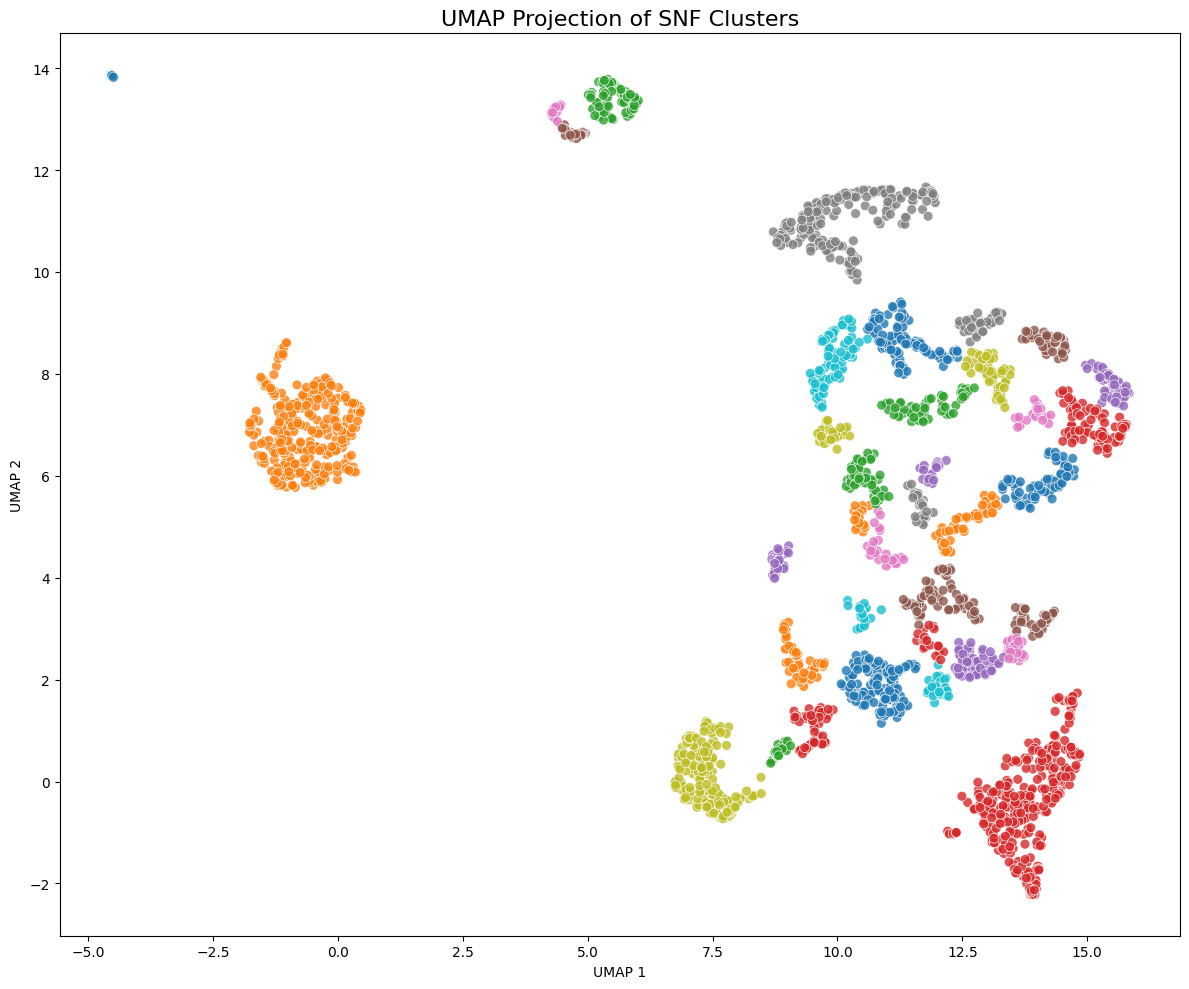

In [4]:
plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=risultati_puliti_2,
    x='UMAP1', 
    y='UMAP2',
    hue='Cluster',
    palette="tab10",
    s=50,
    alpha=0.8,
    legend=False
)
plt.title("UMAP Projection of SNF Clusters", fontsize=16)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.tight_layout()
plt.show()

In [ ]:
def find_cluster_centroids(results_df):
    centroids = results_df.groupby('Cluster')[['UMAP1', 'UMAP2']].mean().reset_index()
    return centroids
centroids = find_cluster_centroids(risultati_puliti_2)

plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=risultati_puliti_2,
    x='UMAP1', 
    y='UMAP2',
    hue='Cluster',
    palette="tab10",
    s=50,
    alpha=0.8,
    legend=False
)

# Plot centroids
sns.scatterplot(
    data=centroids,
    x='UMAP1', 
    y='UMAP2',
    color='black',
    marker='X',
    s=200,
    label='Centroids'
)

plt.title("UMAP Projection with Cluster Centroids", fontsize=16)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.tight_layout()
plt.show()

In [ ]:
def find_closest_genes_to_centroids(results_df, centroids, n_closest=3):
    closest_genes = {}
    
    for _, centroid in centroids.iterrows():
        cluster_id = centroid['Cluster']
        cluster_data = results_df[results_df['Cluster'] == cluster_id]
        distances = np.sqrt(
            (cluster_data['UMAP1'] - centroid['UMAP1']) ** 2 + 
            (cluster_data['UMAP2'] - centroid['UMAP2']) ** 2
        )
        closest_indices = distances.nsmallest(n_closest).index
        closest_genes[cluster_id] = cluster_data.loc[closest_indices, 'Gene'].tolist()
    
    return closest_genes
closest_genes = find_closest_genes_to_centroids(risultati_puliti_2, centroids, n_closest=3)
for cluster, genes in closest_genes.items():
    print(f"Cluster {cluster}: {genes}")

In [ ]:
all_gene_ids = []
for genes in closest_genes.values():
    all_gene_ids.extend(genes)

unique_gene_ids = list(set(all_gene_ids))

api_results = get_gene_names_from_api(unique_gene_ids)

gene_info_map = {}
for item in api_results:
    query_id = item.get('query')
    symbol = item.get('symbol', 'N/A')
    name = item.get('name', 'Descrizione non disponibile')
    
    gene_info_map[query_id] = f"{symbol}: {name}"

for cluster, genes in closest_genes.items():
    print(f"\nCluster {cluster}:")
    for gene_id in genes:
        description = gene_info_map.get(str(gene_id), "Nessun dato trovato su MyGene")
        print(f"  • ID {gene_id} -> {description}")

In [ ]:
df_weights = model.get_weights(views=0, df=True) 

df_weights